# Internal Rating System for Probability of Default using Cox proportional hazard model

The objectif is to predict Default probability using a dataset full of relevant financial indicators. the project took a multifaceted approach, integrating exploratory data analysis, statistical methodologies especially the Cox Model:

### Import necessary packages

In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
#from catboost import CatBoostClassifier
#import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

### Read data

In [379]:
data=pd.read_excel("SNI.xlsx")
data.head()

,numtiers,Annee,NUMTIERS_ANNEE,defaut,DATE_DE_CREATION_TIERS,DATE_DE_CREATION_ENTREP,CHIFFRE_AFFAIRES,EXCEDENT_BRUT_EXPLOITATION,RESULTAT_EXPlOITATION,RESULTAT_NET,...,NIVEAU_COMPETITIVITE,QUALITE_INFORMATION_FINANCIERE,REPUTATION,STRUCTUREDUMANAGEMENT,SUPPORT,POSITIONNEMENTMARCHE,Categorie_juridique,Cote en bourse,Appartenance a un groupe,Secteurs
0,5200000007513,2015,5200000007513_2015,0,2008-01-02,1982-01-05,236073240.2,8258201.71,7120503.00,-14040379.78,...,Quelques competiteurs majeurs identifies,Etats comptables et financiers audites par un ...,Bonne,Bien structure,Support conforme aux attentes,Acteur majeur + de 20% de part de marche,SA,0,0,Transport et Communication
1,5200000007513,2016,5200000007513_2016,0,2008-01-02,1982-01-05,258386615.0,4107268.85,2031311.93,2312466.82,...,Tres forte concurrence,Etats comptables et financiers audites par un ...,Tres bonne,Bien structure,Support conforme aux attentes,Acteur majeur + de 20% de part de marche,SA,0,0,Transport et Communication
2,5200000007934,2015,5200000007934_2015,0,1988-05-31,1953-08-05,202426475.2,5028464.60,3602225.77,-413273.04,...,Absence de concurrence (quasi monopole),Etats comptables et financiers audites par un ...,Tres bonne,Bien structure,Support conforme aux attentes,Leader,SA,0,1,Industries agroalimentaires et du tabac
3,5200000007934,2017,5200000007934_2017,0,1988-05-31,1953-08-05,210917616.4,13076487.89,12514233.63,7501946.85,...,Forte presence de produits similaires et compe...,Etats comptables et financiers audites par un ...,Tres bonne,Bien structure,Support conforme aux attentes,Acteur majeur + de 20% de part de marche,SA,0,1,Industries agroalimentaires et du tabac
4,5200000008051,2015,5200000008051_2015,0,1998-10-02,1995-05-22,171987524.1,16142629.85,12544851.82,1401029.14,...,Quelques competiteurs majeurs identifies,Etats comptables et financiers audites par un ...,Tres bonne,Bien structure,Support conforme aux attentes,Acteur non significatif,SA,0,1,"Commerce, reparations automobiles et d'article..."


### Check Data

In [380]:
for col in data.columns:
    if data[col].dtype=="object":
        unique_values = data[col].unique()
        print(f"Unique values in {col} column:")
        print(unique_values)
        print("\n")

Unique values in NUMTIERS_ANNEE column:
['5200000007513_2015' '5200000007513_2016' '5200000007934_2015' ...
 '5200007684315_2018' '5200007955060_2019' '5200008030705_2015']


Unique values in EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT column:
['Entre 5 et 10 ans' 'Plus de 10 ans' 'Inferieure e 5 ans' 'Modalite vide']


Unique values in DIVERSITE_CLIENTS column:
['Diversification tres forte par produits, clients, situation geographique'
 'Diversification limitee e un seul client ou un seul produit ou e une seule zone geographique'
 'Bonne diversification par produits mais limitee e une zone geographique ou e quelques client'
 'Forte dependance e quelques clients mais limitee e un seul produit'
 'Diversification très forte par produits,clients, situation geographique'
 'Diversification très forte par produits, clients, situation geographique'
 'Modalite vide']


Unique values in DIVERSITE_FOURNISSEURS column:
['Tres grande diversite' 'Diversite moyenne' 'Pas de diversite'
 'Diversite insufi

Some steps of data validation and cleaning are necessary before moving on

In [381]:
data["DIVERSITE_CLIENTS"].replace('Diversification très forte par produits,clients, situation geographique', 'Diversification tres forte par produits, clients, situation geographique', inplace=True)
data["DIVERSITE_CLIENTS"].replace('Diversification très forte par produits, clients, situation geographique', 'Diversification tres forte par produits, clients, situation geographique', inplace=True)
data["DIVERSITE_FOURNISSEURS"].replace('Tres grande diversite', 'Très grande diversite', inplace=True)
data["IMPACT_SOCIAUX_ENVIRONNEMENTAL"].replace('Aucun impact social ou environnemental, soumis e une reglementation', 'Aucun impact social ou environnemental, soumis à une reglementation', inplace=True)
data["NIVEAU_COMPETITIVITE"].replace('Tres forte concurrence', 'Très forte concurrence', inplace=True)
data["REPUTATION"].replace('Tres bonne', 'Très bonne', inplace=True)
for col in data.columns:
    if data[col].dtype=="object":
        unique_values = data[col].unique()
        print(f"Unique values in {col} column:")
        print(unique_values)
        print("\n")

Unique values in NUMTIERS_ANNEE column:
['5200000007513_2015' '5200000007513_2016' '5200000007934_2015' ...
 '5200007684315_2018' '5200007955060_2019' '5200008030705_2015']


Unique values in EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT column:
['Entre 5 et 10 ans' 'Plus de 10 ans' 'Inferieure e 5 ans' 'Modalite vide']


Unique values in DIVERSITE_CLIENTS column:
['Diversification tres forte par produits, clients, situation geographique'
 'Diversification limitee e un seul client ou un seul produit ou e une seule zone geographique'
 'Bonne diversification par produits mais limitee e une zone geographique ou e quelques client'
 'Forte dependance e quelques clients mais limitee e un seul produit'
 'Modalite vide']


Unique values in DIVERSITE_FOURNISSEURS column:
['Très grande diversite' 'Diversite moyenne' 'Pas de diversite'
 'Diversite insufisante' 'Modalite vide']


Unique values in IMPACT_SOCIAUX_ENVIRONNEMENTAL column:
['Impact social ou environnemental potentiel mais reversible'
 'Impac

In [382]:
float_columns=data.select_dtypes(include='float64').columns
len(float_columns)

20

### Data visualization

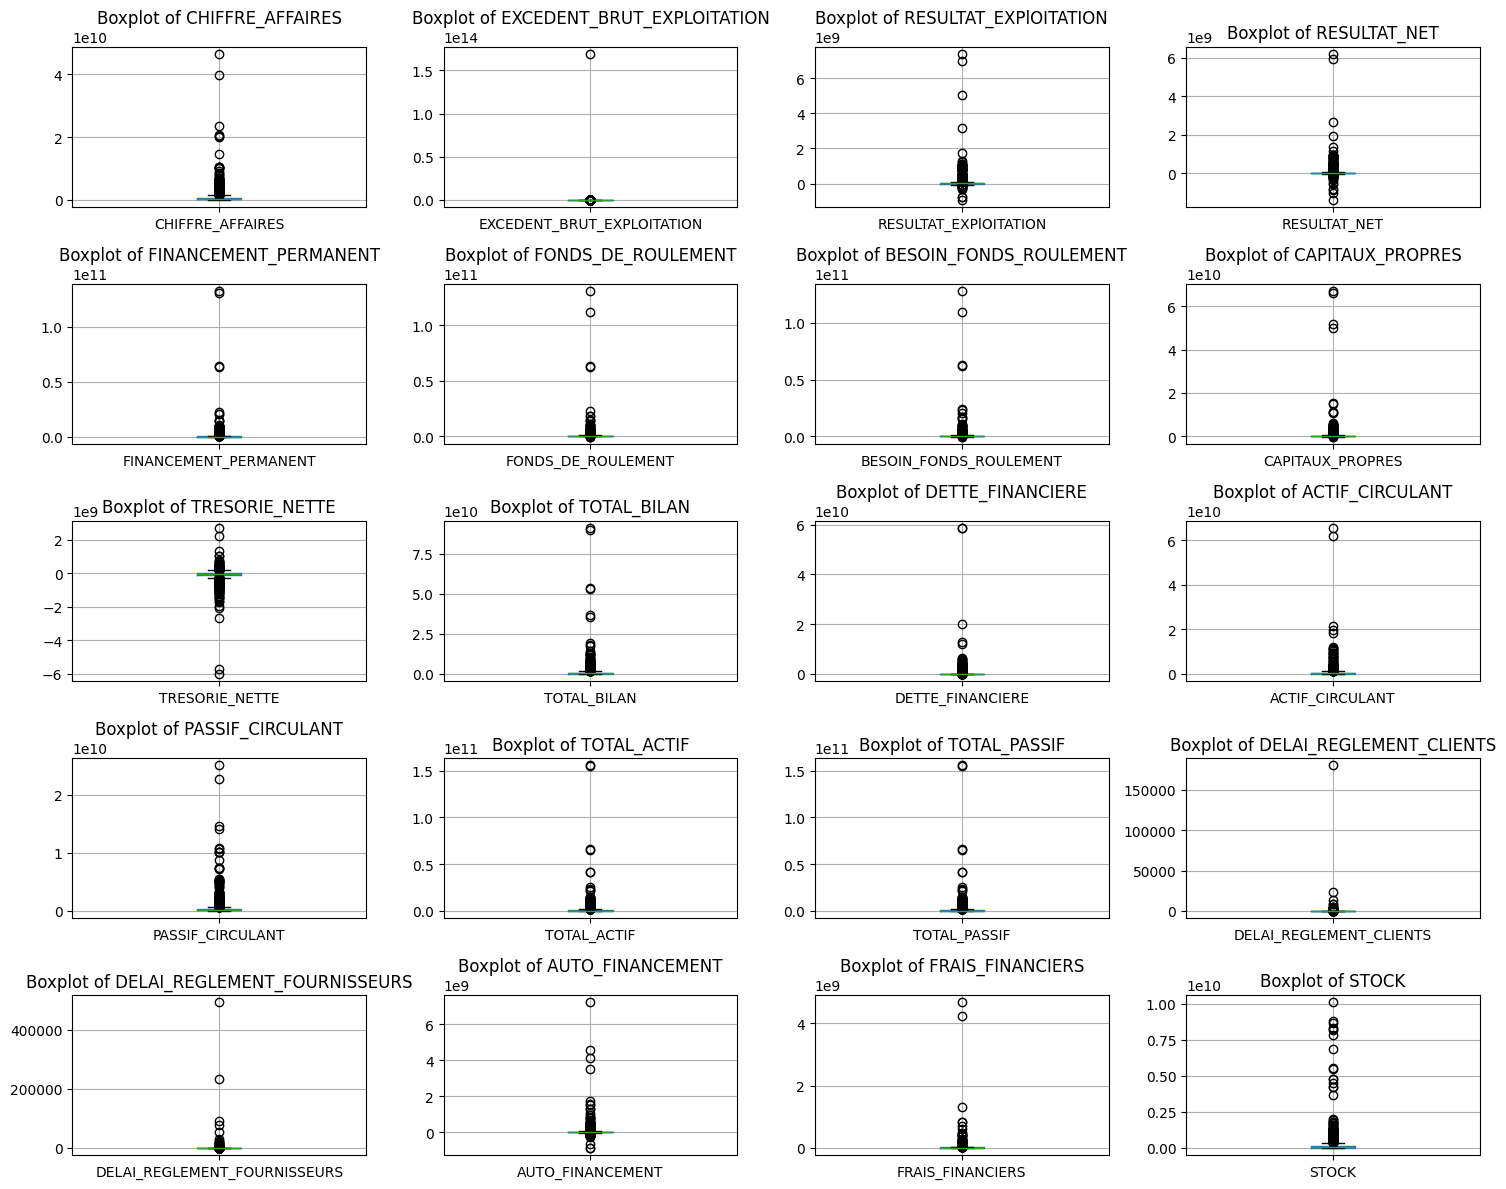

In [383]:
num_cols = 4
num_rows = len(float_columns) // num_cols + (len(float_columns) % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))

axes = axes.flatten()

for i, col in enumerate(float_columns):
    ax = axes[i]
    data.boxplot(column=col, ax=ax)
    ax.set_title(f'Boxplot of {col}')

for i in range(len(float_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Visualize the default items

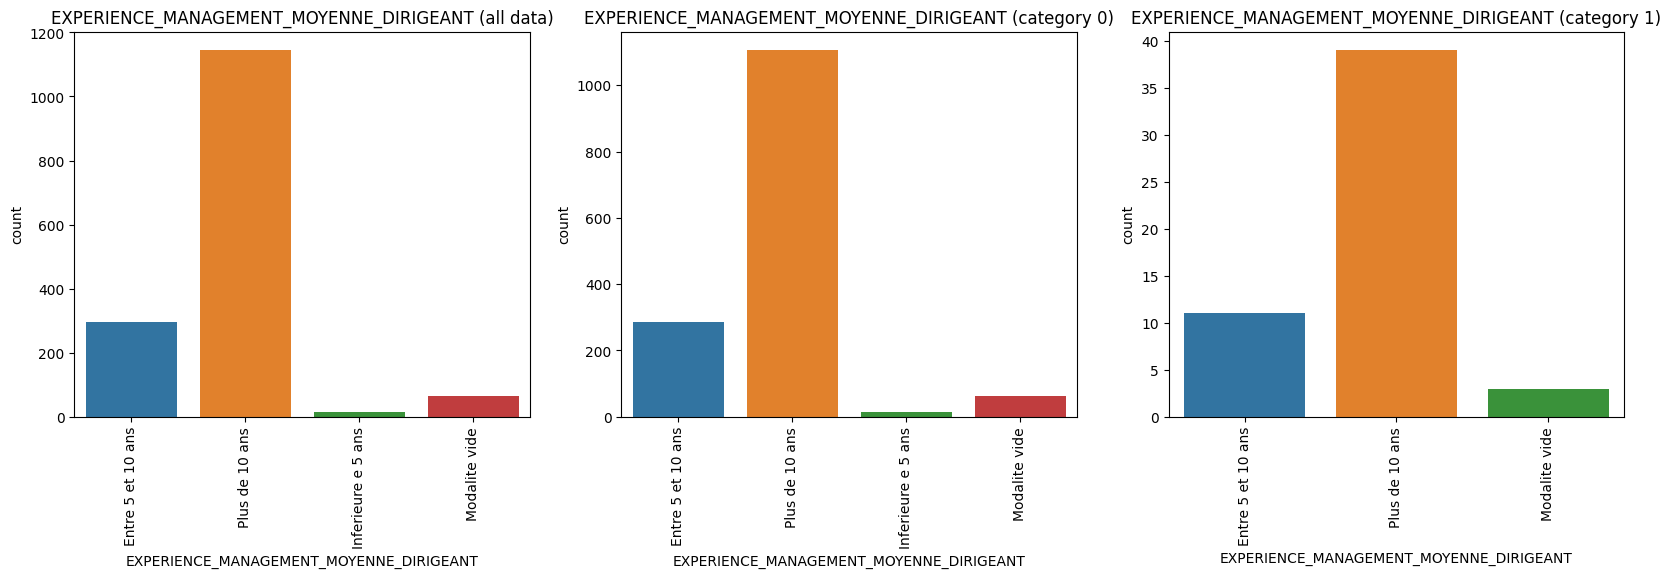

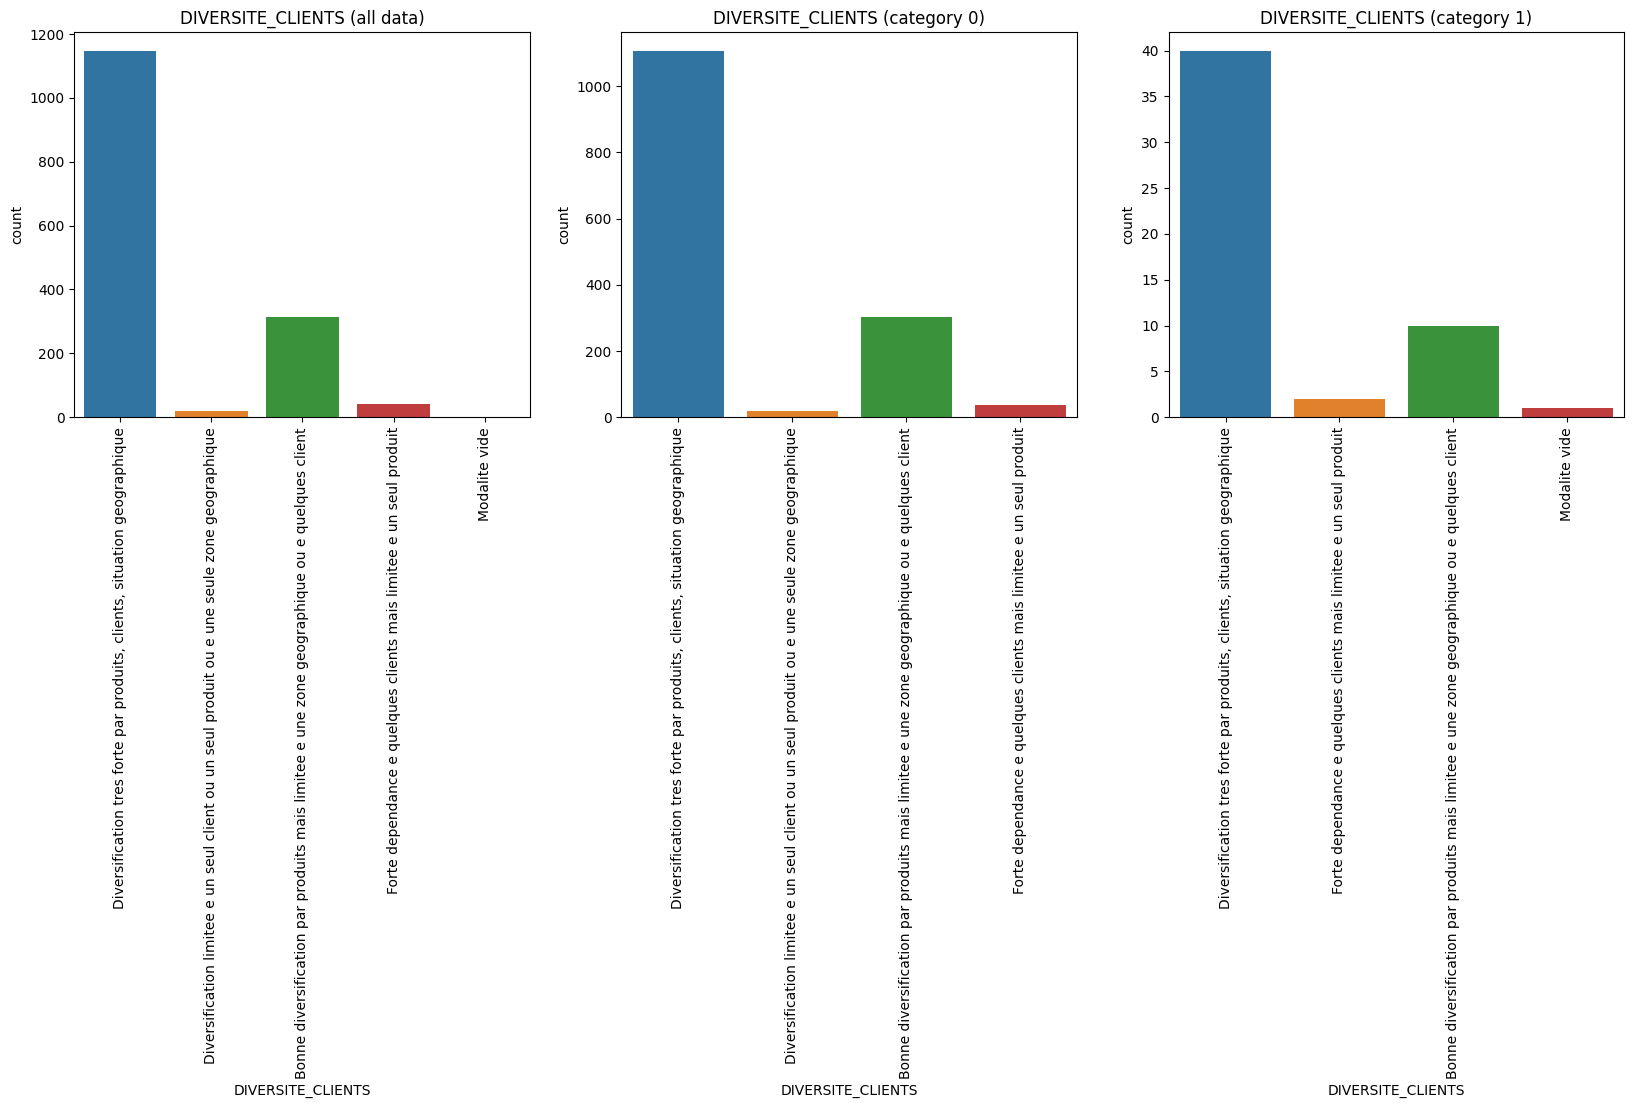

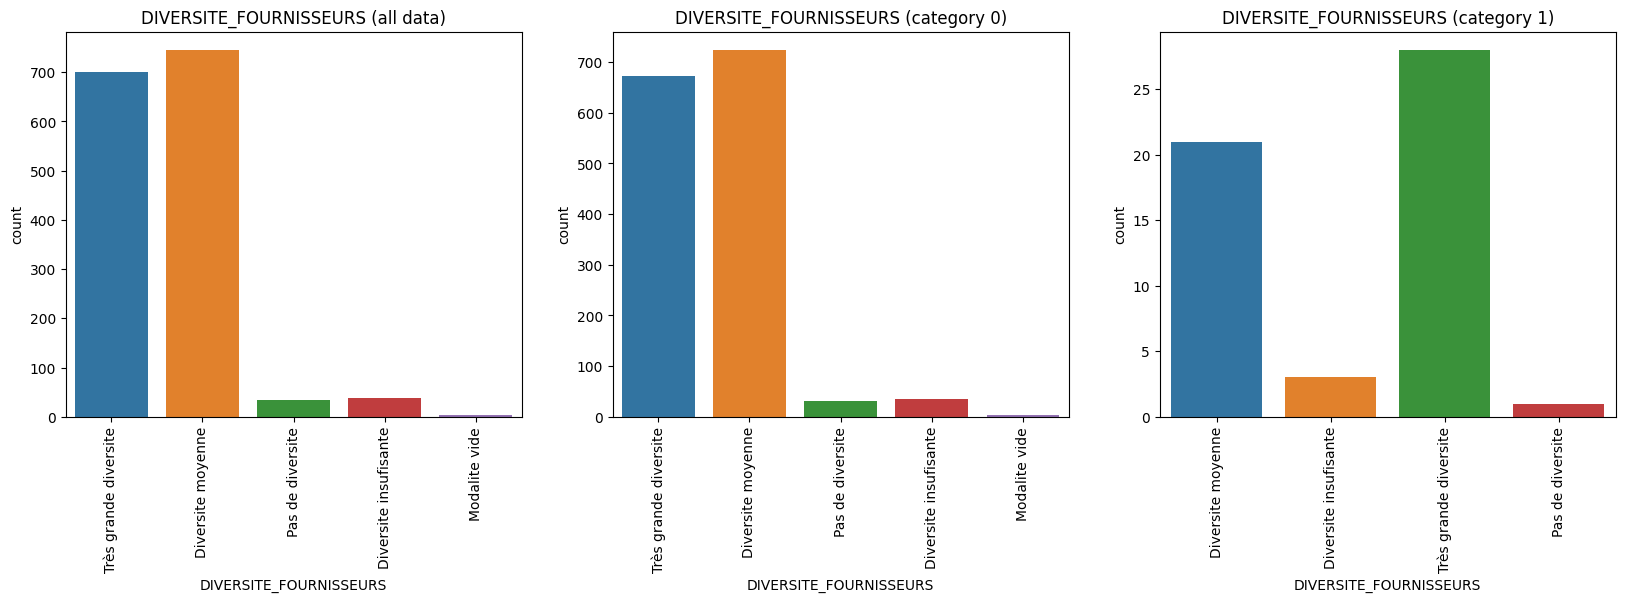

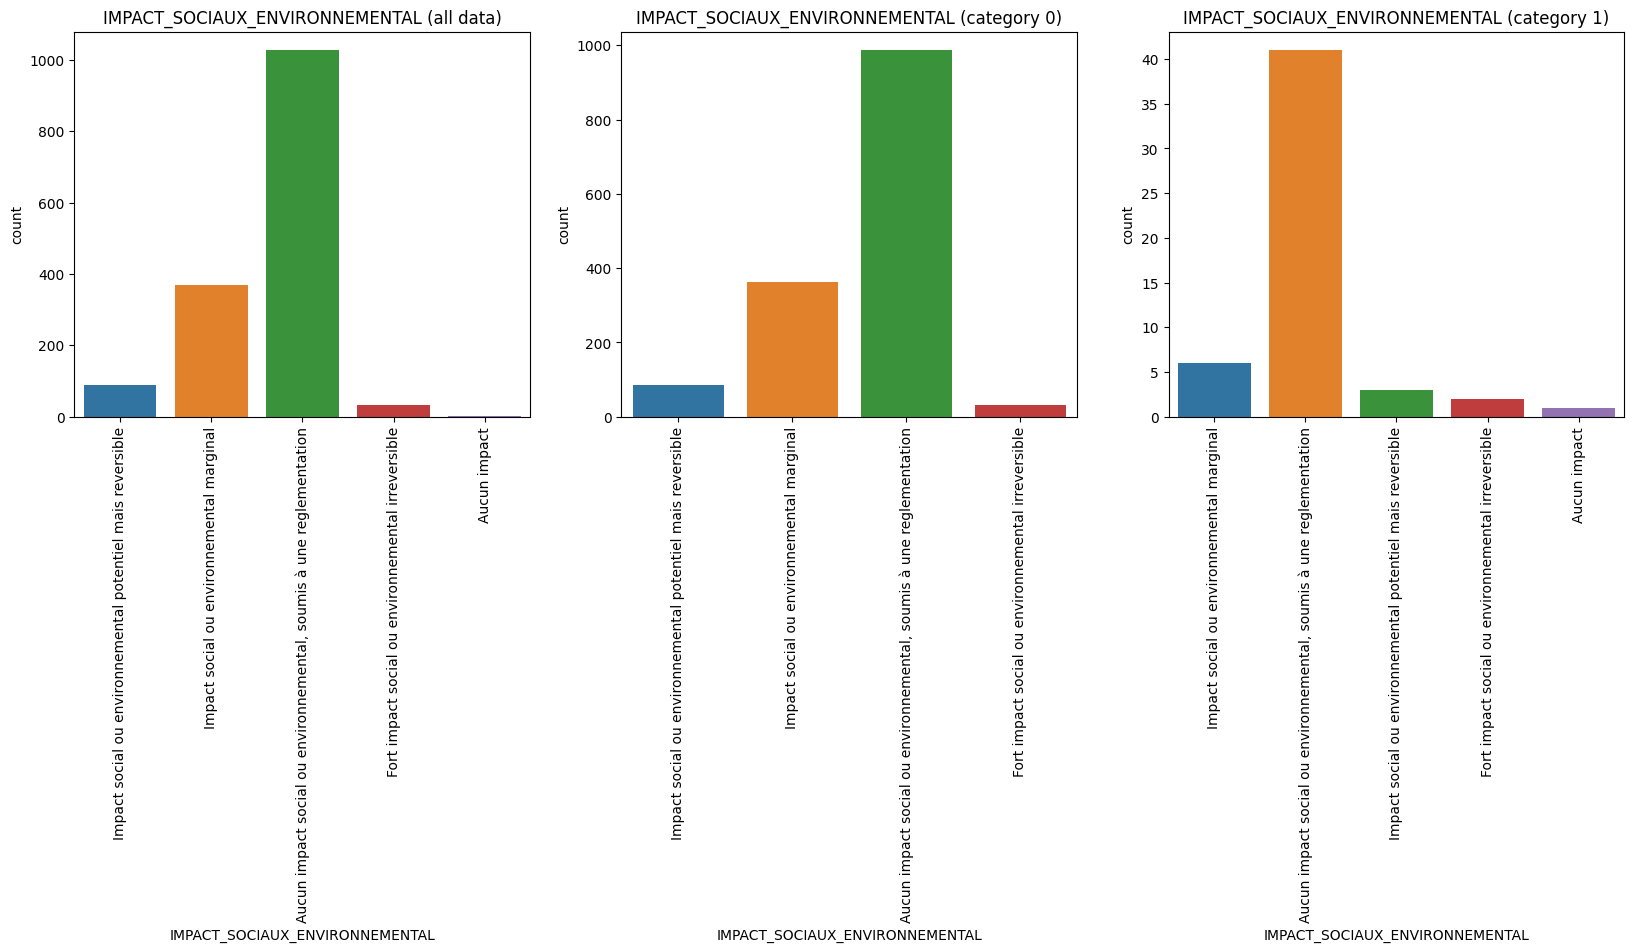

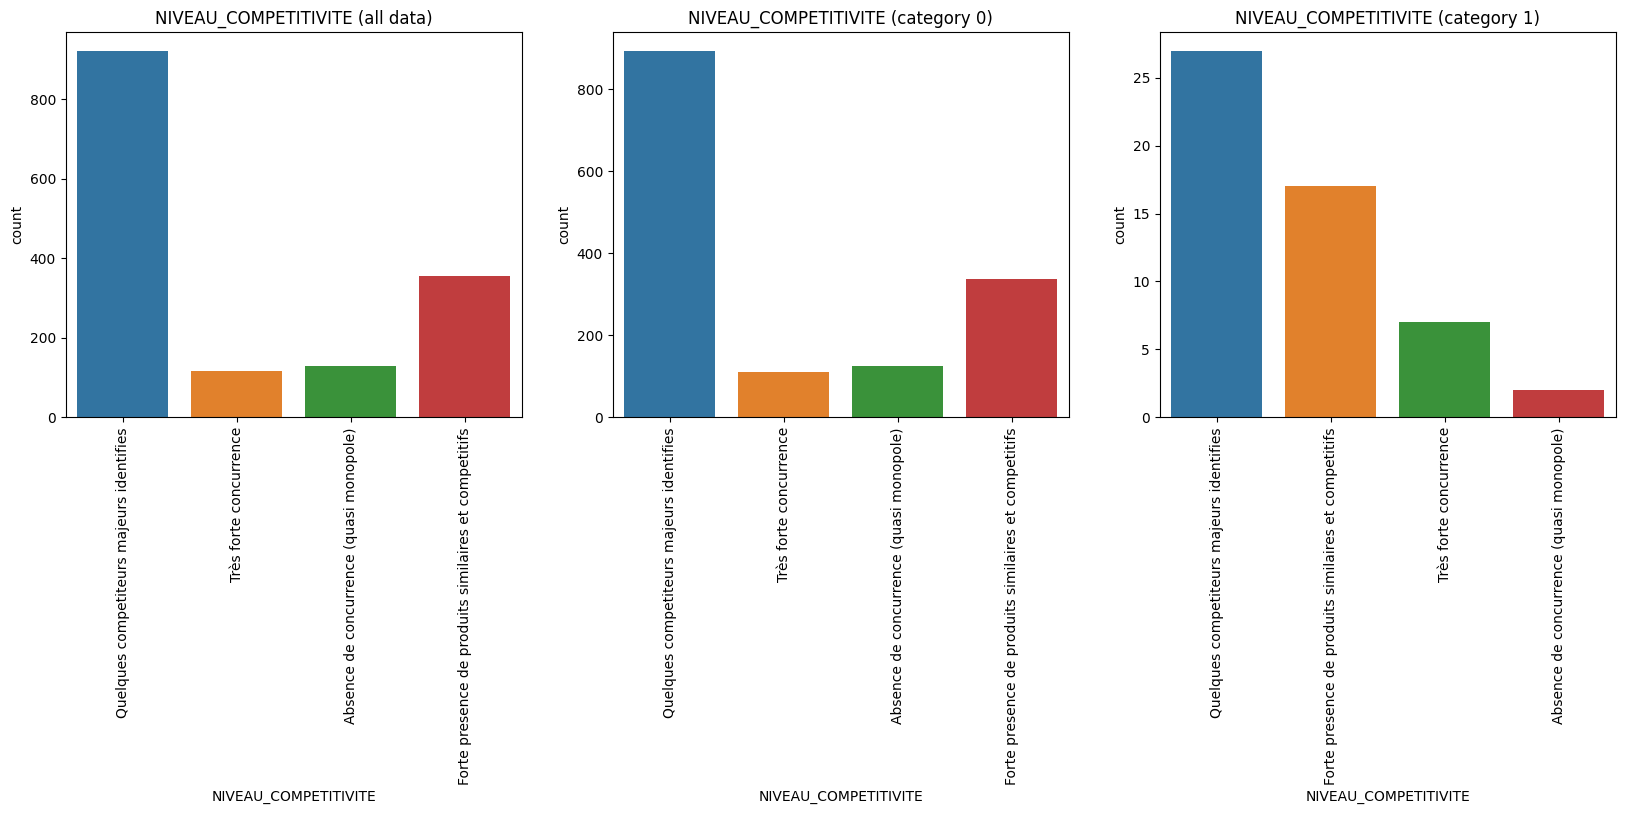

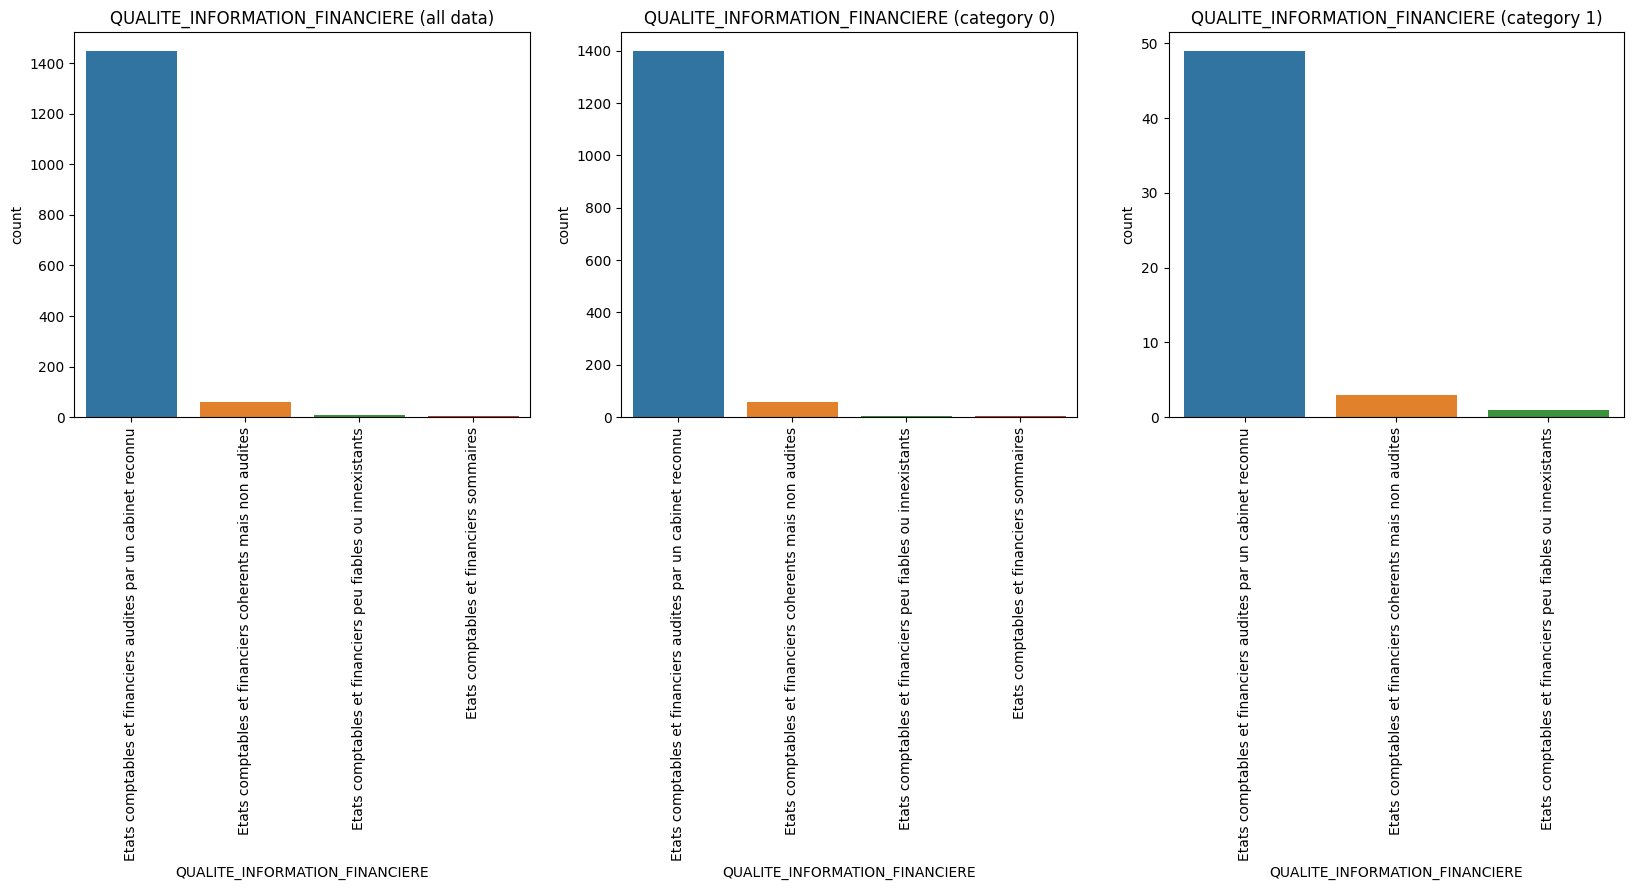

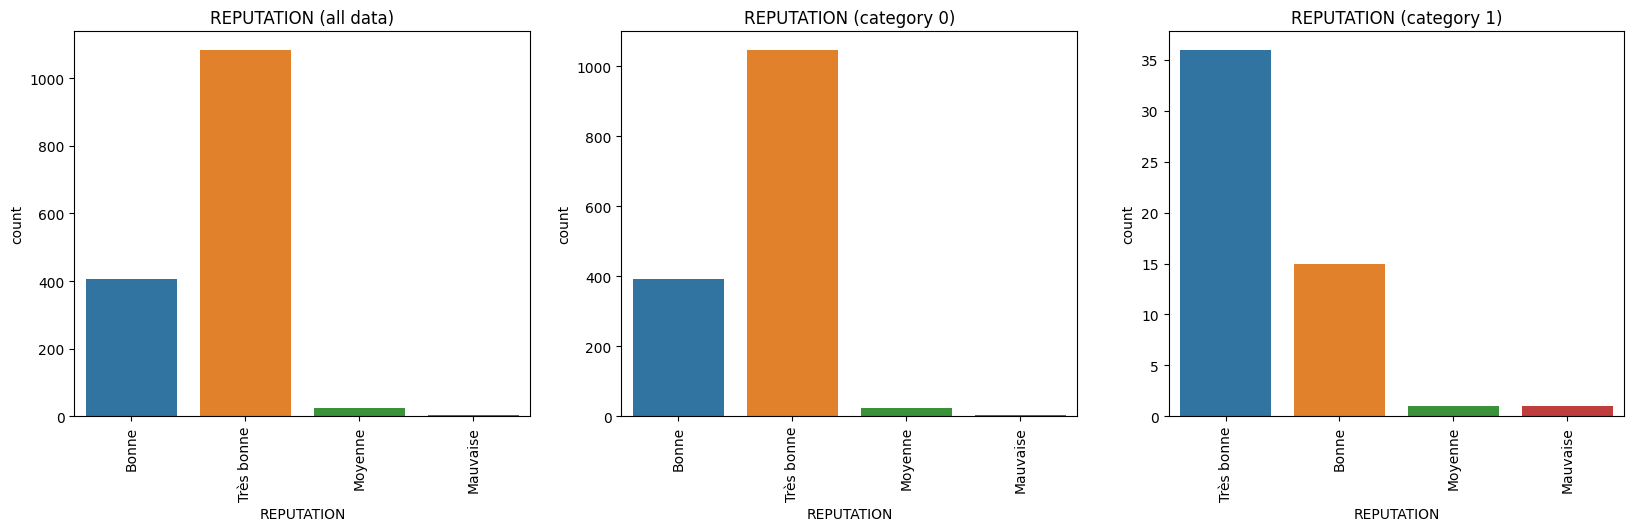

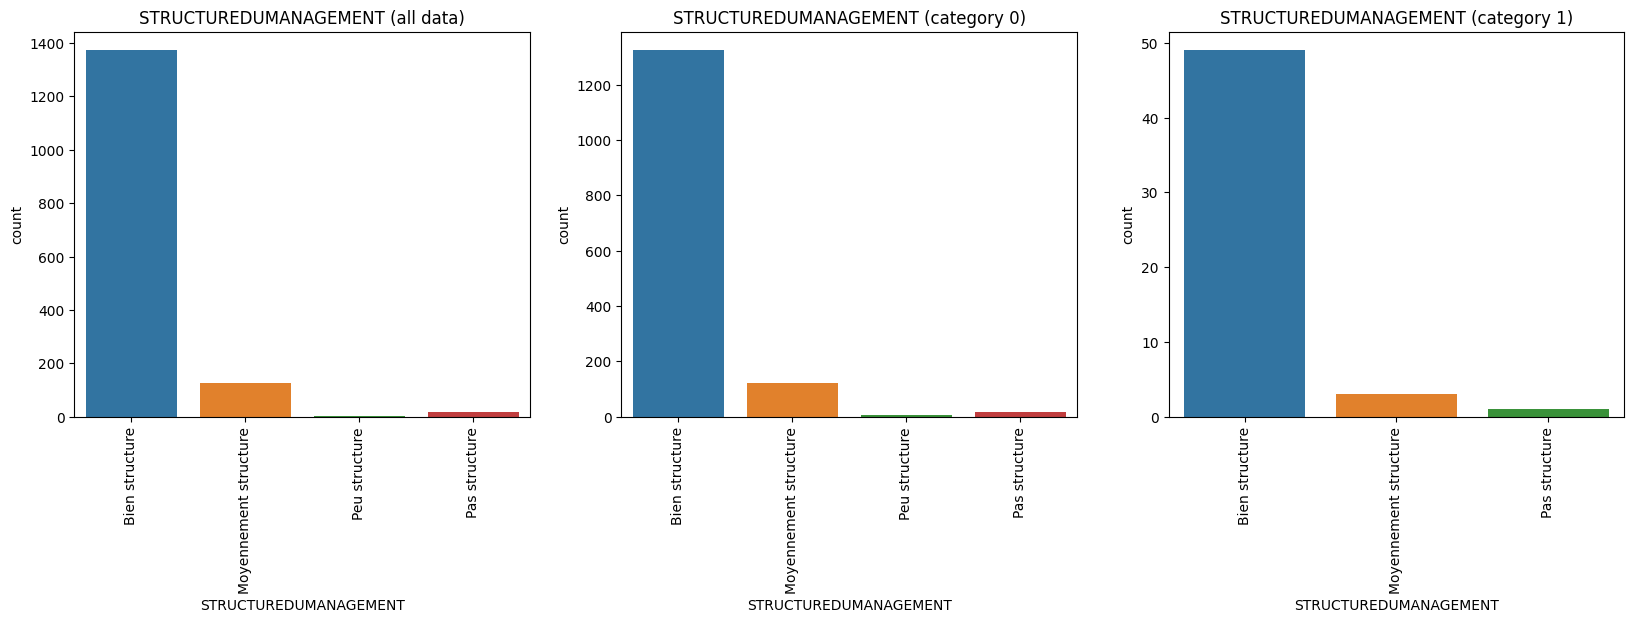

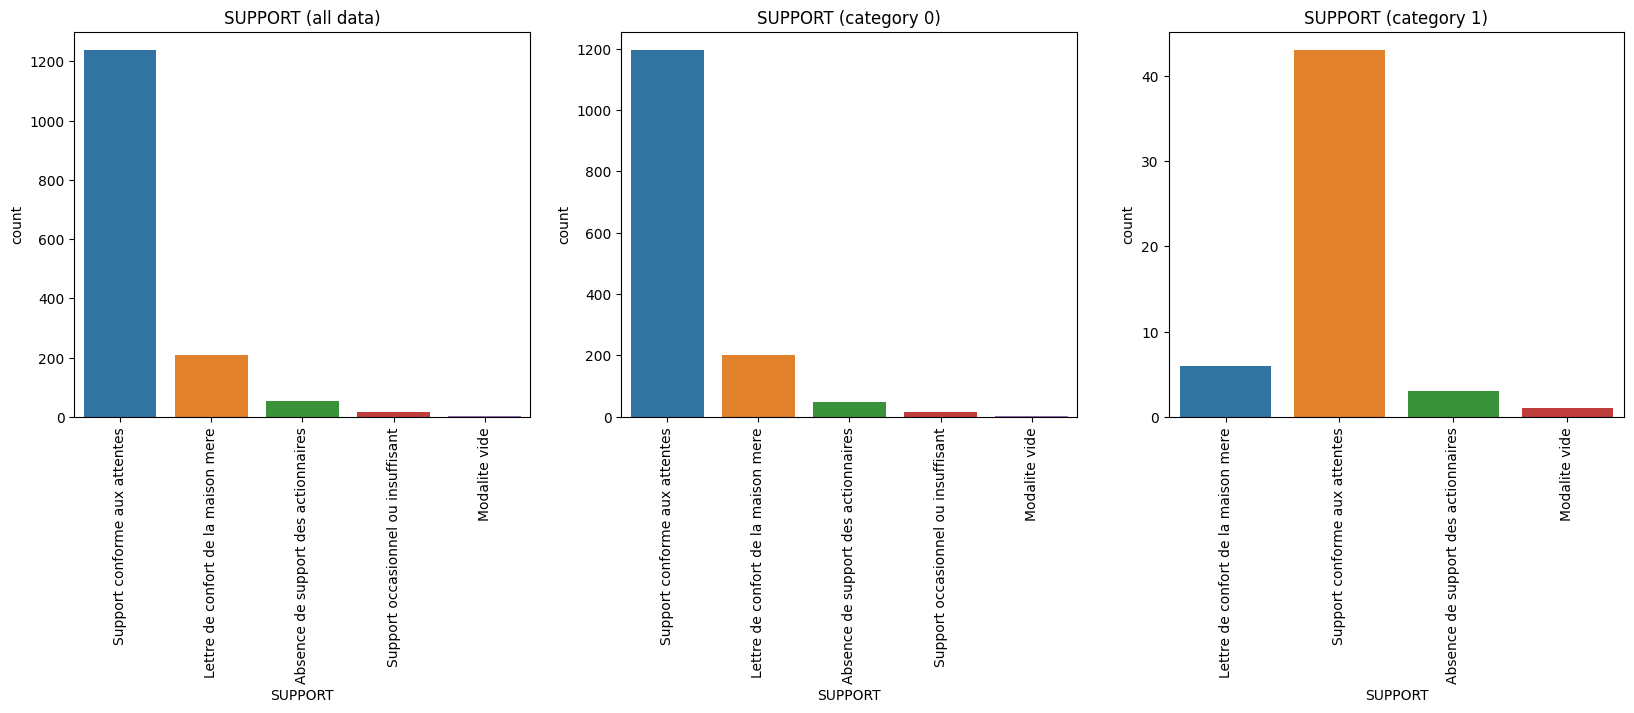

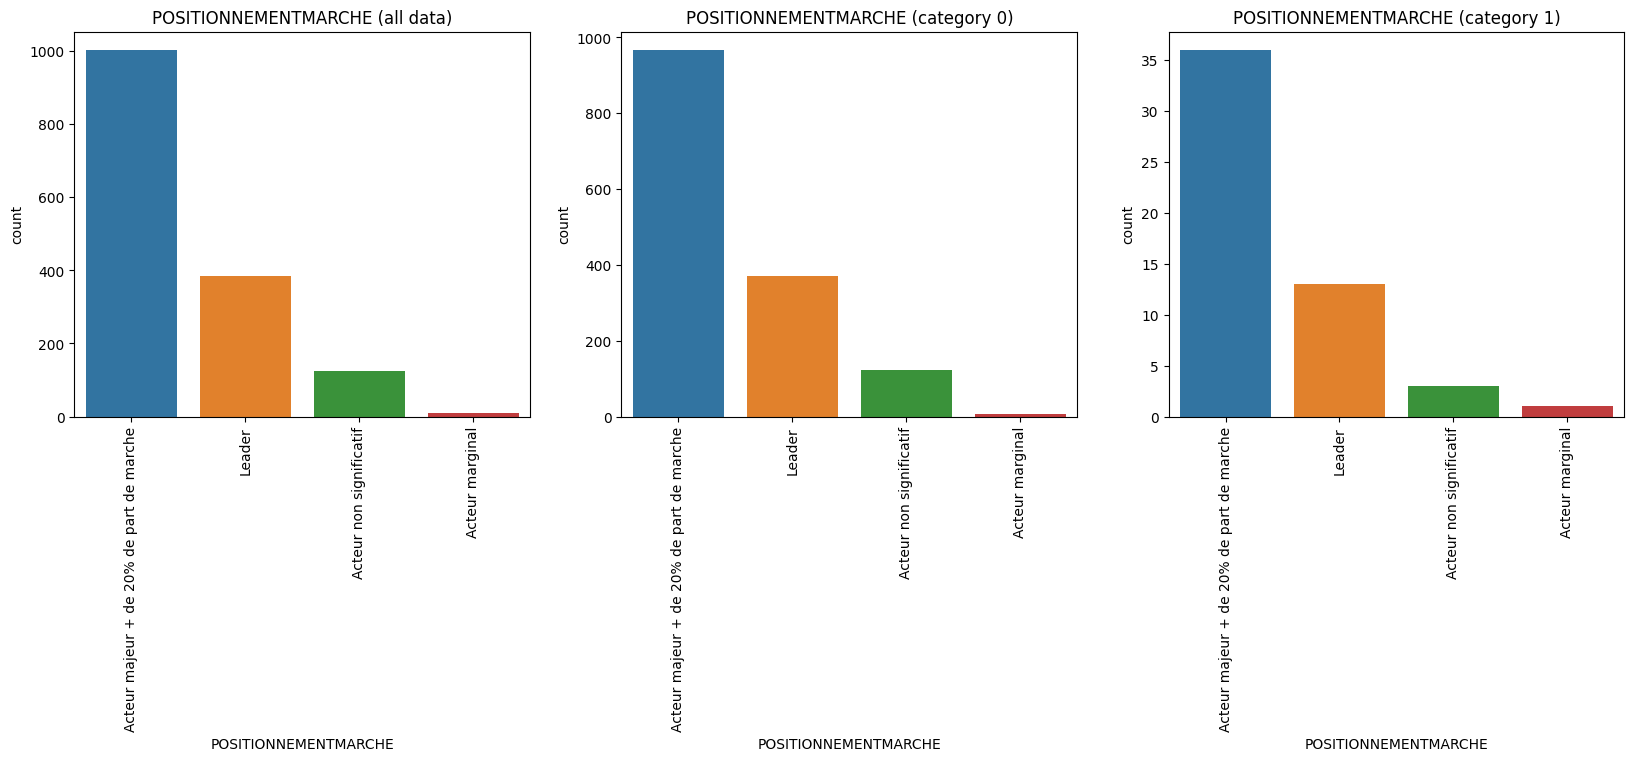

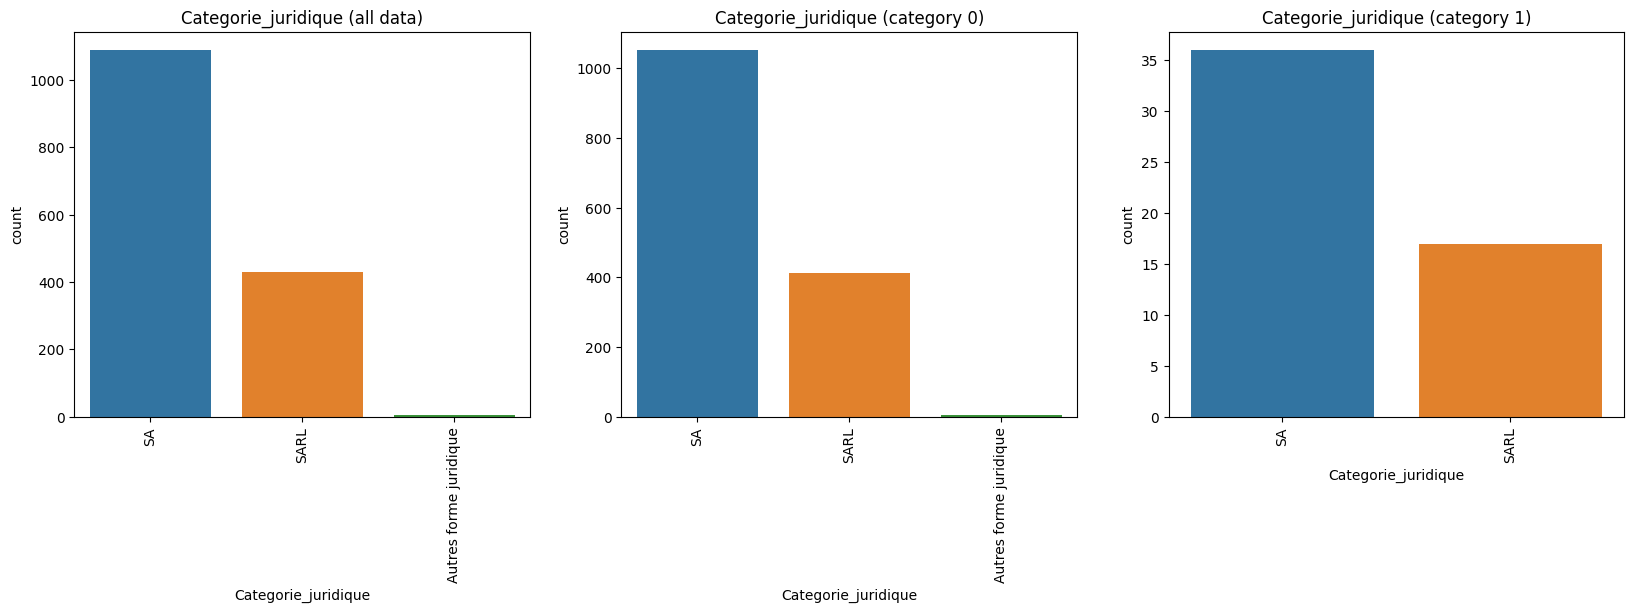

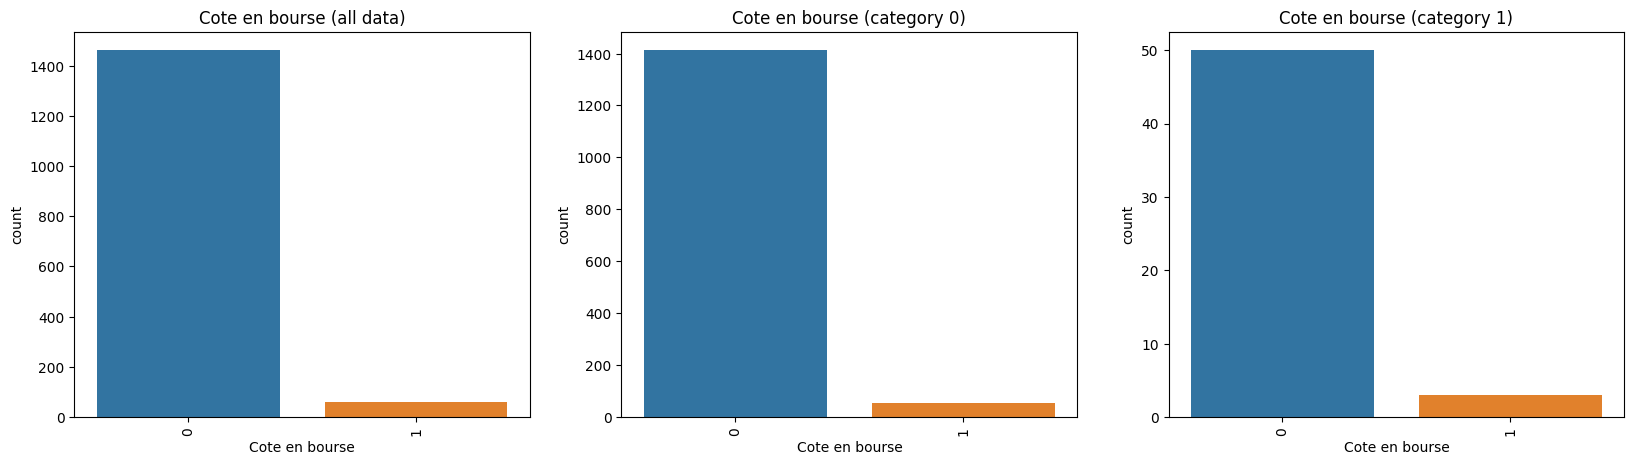

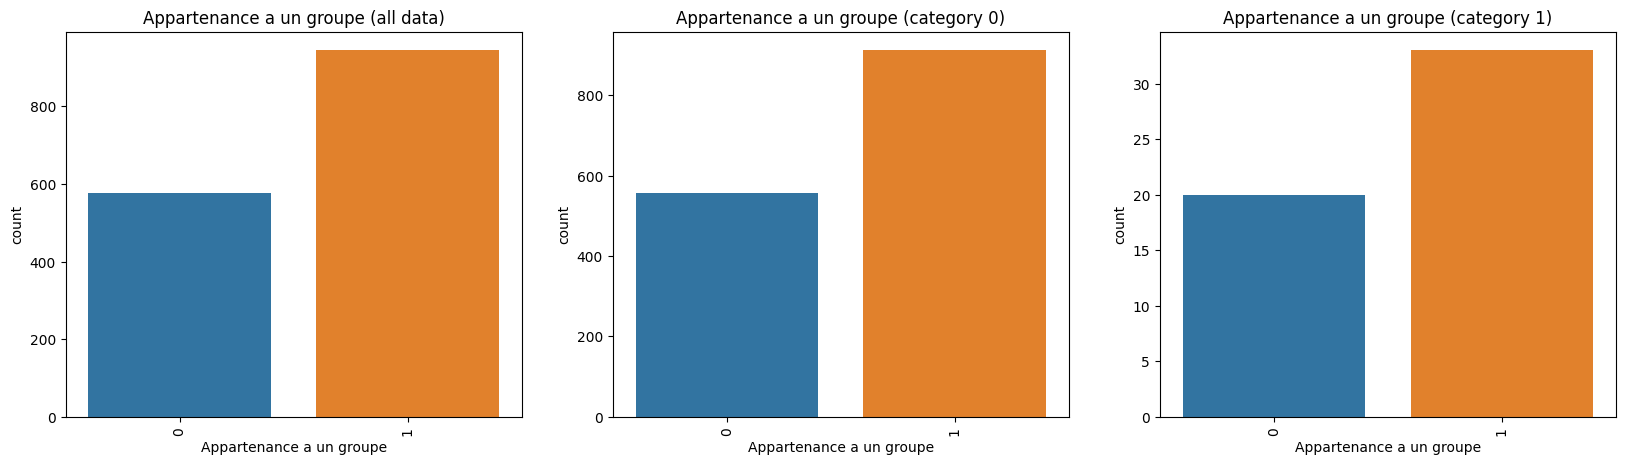

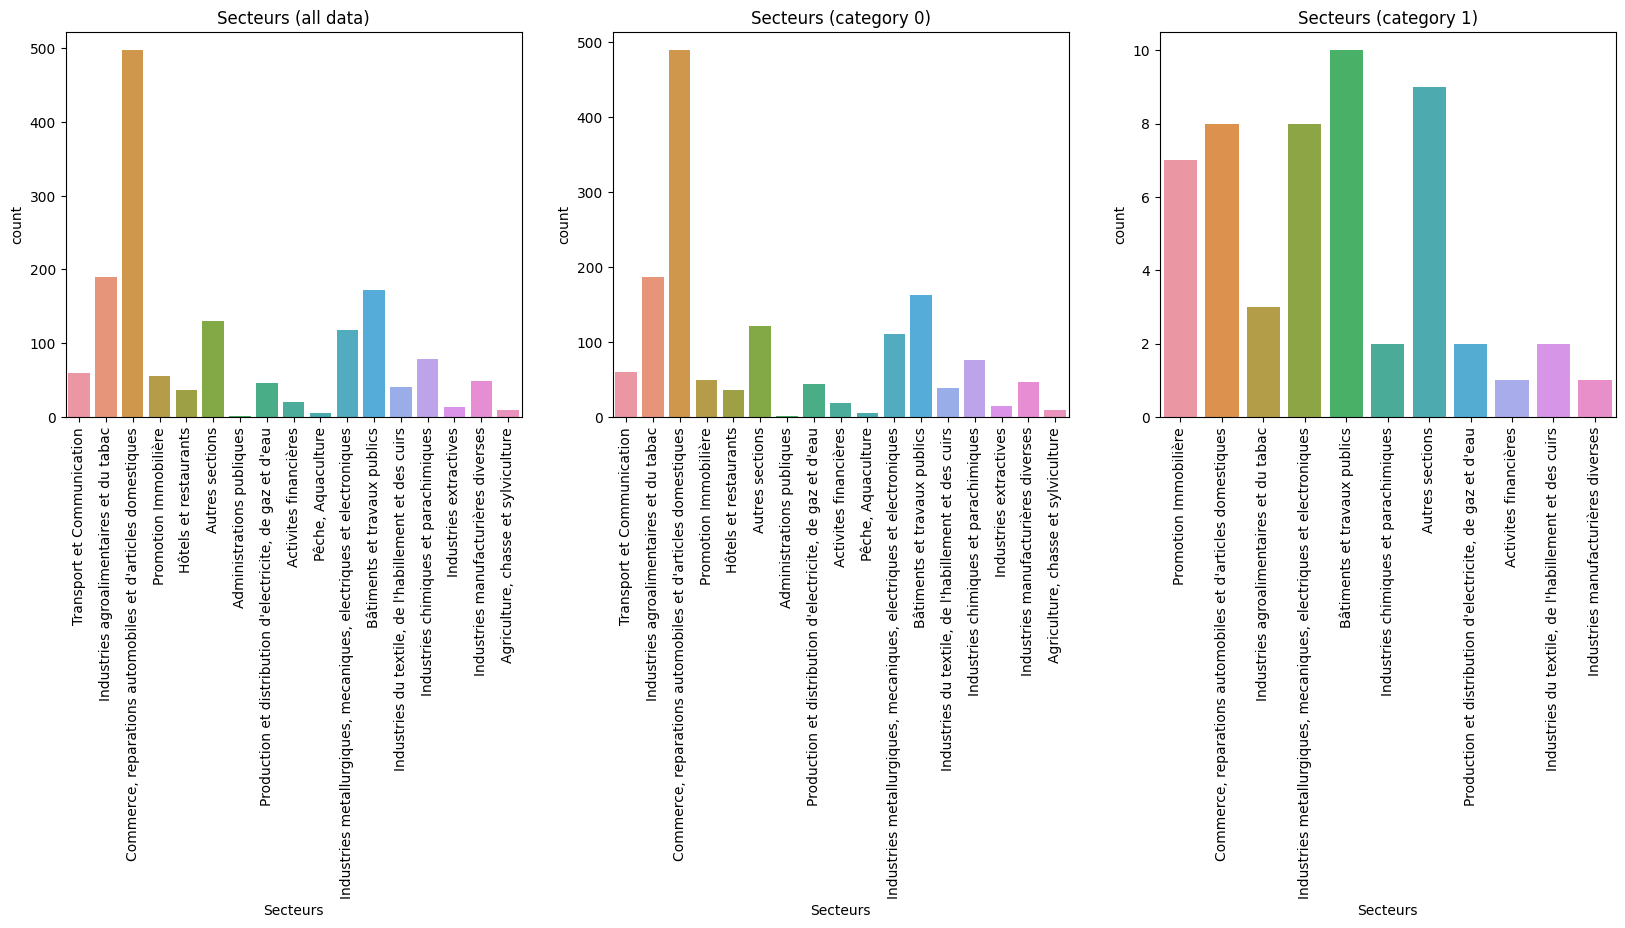

In [384]:

columns = ['EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT', 'DIVERSITE_CLIENTS',
           'DIVERSITE_FOURNISSEURS', 'IMPACT_SOCIAUX_ENVIRONNEMENTAL',
           'NIVEAU_COMPETITIVITE', 'QUALITE_INFORMATION_FINANCIERE', 'REPUTATION',
           'STRUCTUREDUMANAGEMENT', 'SUPPORT', 'POSITIONNEMENTMARCHE',
           'Categorie_juridique', 'Cote en bourse', 'Appartenance a un groupe',
           'Secteurs']


if 'defaut' in data.columns:
    for column in columns:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

        # All data
        sns.countplot(x=data[column], ax=ax[0])
        ax[0].set_title(column + ' (all data)')
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

        # Category 0
        sns.countplot(x=data[column][data['defaut'] == 0], ax=ax[1])
        ax[1].set_title(column + ' (category 0)')
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

        # Category 1
        sns.countplot(x=data[column][data['defaut'] == 1], ax=ax[2])
        ax[2].set_title(column + ' (category 1)')
        ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)

        plt.show()
else:
    print("'defaut' column not found in the DataFrame.")


In [385]:
data.shape

(1521, 40)

### Check null values

In [386]:
# Count zeros in each column
zero_counts = data.eq(0).sum()

print(zero_counts)

numtiers                                      0
Annee                                         0
NUMTIERS_ANNEE                                0
defaut                                     1468
DATE_DE_CREATION_TIERS                        0
DATE_DE_CREATION_ENTREP                       0
CHIFFRE_AFFAIRES                              0
EXCEDENT_BRUT_EXPLOITATION                    6
RESULTAT_EXPlOITATION                         4
RESULTAT_NET                                 13
FINANCEMENT_PERMANENT                         1
FONDS_DE_ROULEMENT                            0
BESOIN_FONDS_ROULEMENT                        0
CAPITAUX_PROPRES                              4
TRESORIE_NETTE                                1
TOTAL_BILAN                                   1
DETTE_FINANCIERE                            563
ACTIF_CIRCULANT                               3
PASSIF_CIRCULANT                              1
TOTAL_ACTIF                                   3
TOTAL_PASSIF                            

null values in columns like (default, stock, cote en bourse, appartenance a un groupe) are normal but in columns like (equity, total assets, liabilities..) are not evident and may generate errors and problems later 

In [387]:
# Sort the DataFrame by 'numtiers' and 'Annee'
sorted_data = data.sort_values(by=['numtiers', 'Annee'])

In [388]:
l_cap_pro=list(sorted_data[sorted_data['CAPITAUX_PROPRES']==0]['numtiers'])
l_tot_act=list(sorted_data[sorted_data['TOTAL_ACTIF']==0]['numtiers'])
l_pass_cir=list(sorted_data[sorted_data['PASSIF_CIRCULANT']==0]['numtiers'])


### Impute null values by the next year's value for the same company 

In [389]:
print(sorted_data[sorted_data['numtiers'].isin(l_cap_pro)].sort_values(by=['numtiers','Annee'])[['numtiers','Annee', 'CAPITAUX_PROPRES']])

# Replace 0 values with NaN in 'CAPITAUX_PROPRES' column
sorted_data['CAPITAUX_PROPRES'].replace(0, np.nan, inplace=True)
# Forward fill null values in 'CAPITAUX_PROPRES' column within each 'numtiers' group
sorted_data['CAPITAUX_PROPRES'] = sorted_data.groupby('numtiers')['CAPITAUX_PROPRES'].transform(lambda x: x.fillna(method='ffill'))
# If there are still null values remaining, fill them with the next year's value
sorted_data['CAPITAUX_PROPRES'] = sorted_data.groupby('numtiers')['CAPITAUX_PROPRES'].transform(lambda x: x.fillna(method='bfill'))

print()
print(sorted_data[sorted_data['numtiers'].isin(l_cap_pro)].sort_values(by=['numtiers','Annee'])[['numtiers','Annee', 'CAPITAUX_PROPRES']])


           numtiers  Annee  CAPITAUX_PROPRES
375   5200001299269   2015              0.00
1103  5200001299269   2016       54245661.03
376   5200001299269   2017       40299730.56
1104  5200001299269   2018       57384717.74
1105  5200001299269   2019       39770154.20
399   5200001300441   2015       54175671.89
1117  5200001300441   2016              0.00
1118  5200001300441   2017       60043790.03
400   5200001300441   2018       57058559.74
1119  5200001300441   2019       69106903.78
1292  5200007203033   2015       35875963.98
778   5200007203033   2016              0.00
779   5200007203033   2017       76025022.54
780   5200007203033   2018              0.00
1293  5200007203033   2019       79319783.03

           numtiers  Annee  CAPITAUX_PROPRES
375   5200001299269   2015       54245661.03
1103  5200001299269   2016       54245661.03
376   5200001299269   2017       40299730.56
1104  5200001299269   2018       57384717.74
1105  5200001299269   2019       39770154.20
399   520

In [390]:
print(sorted_data[sorted_data['numtiers'].isin(l_tot_act)].sort_values(by=['numtiers','Annee'])[['numtiers','Annee', 'TOTAL_ACTIF']])
# Replace 0 values with NaN in 'TOTAL_ACTIF' column
sorted_data['TOTAL_ACTIF'].replace(0, np.nan, inplace=True)
# Forward fill null values in 'TOTAL_ACTIF' column within each 'numtiers' group
sorted_data['TOTAL_ACTIF'] = sorted_data.groupby('numtiers')['TOTAL_ACTIF'].transform(lambda x: x.fillna(method='ffill'))
# If there are still null values remaining, fill them with the next year's value
sorted_data['TOTAL_ACTIF'] = sorted_data.groupby('numtiers')['TOTAL_ACTIF'].transform(lambda x: x.fillna(method='bfill'))

print()
print(sorted_data[sorted_data['numtiers'].isin(l_tot_act)].sort_values(by=['numtiers','Annee'])[['numtiers','Annee', 'TOTAL_ACTIF']])

           numtiers  Annee   TOTAL_ACTIF
399   5200001300441   2015  0.000000e+00
1117  5200001300441   2016  3.649551e+08
1118  5200001300441   2017  3.555540e+08
400   5200001300441   2018  3.924325e+08
1119  5200001300441   2019  3.692892e+08
620   5200001375393   2015  0.000000e+00
621   5200001375393   2016  3.170317e+08
1210  5200001375393   2017  4.530718e+08
622   5200001375393   2018  4.681843e+08
848   5200007709119   2015  9.900310e+07
1315  5200007709119   2016  7.730338e+07
1316  5200007709119   2017  0.000000e+00

           numtiers  Annee   TOTAL_ACTIF
399   5200001300441   2015  3.649551e+08
1117  5200001300441   2016  3.649551e+08
1118  5200001300441   2017  3.555540e+08
400   5200001300441   2018  3.924325e+08
1119  5200001300441   2019  3.692892e+08
620   5200001375393   2015  3.170317e+08
621   5200001375393   2016  3.170317e+08
1210  5200001375393   2017  4.530718e+08
622   5200001375393   2018  4.681843e+08
848   5200007709119   2015  9.900310e+07
1315  520000770

In [391]:
print(sorted_data[sorted_data['numtiers'].isin(l_pass_cir)].sort_values(by=['numtiers','Annee'])[['numtiers','Annee', 'PASSIF_CIRCULANT']])
# Replace 0 values with NaN in 'PASSIF_CIRCULANT' column
sorted_data['PASSIF_CIRCULANT'].replace(0, np.nan, inplace=True)
# Forward fill null values in 'PASSIF_CIRCULANT' column within each 'numtiers' group
sorted_data['PASSIF_CIRCULANT'] = sorted_data.groupby('numtiers')['PASSIF_CIRCULANT'].transform(lambda x: x.fillna(method='ffill'))
# If there are still null values remaining, fill them with the next year's value
sorted_data['PASSIF_CIRCULANT'] = sorted_data.groupby('numtiers')['PASSIF_CIRCULANT'].transform(lambda x: x.fillna(method='bfill'))

print()
print(sorted_data[sorted_data['numtiers'].isin(l_pass_cir)].sort_values(by=['numtiers','Annee'])[['numtiers','Annee', 'PASSIF_CIRCULANT']])

           numtiers  Annee  PASSIF_CIRCULANT
399   5200001300441   2015       168122825.0
1117  5200001300441   2016               0.0
1118  5200001300441   2017       214084776.0
400   5200001300441   2018       243638371.7
1119  5200001300441   2019       238204313.3

           numtiers  Annee  PASSIF_CIRCULANT
399   5200001300441   2015       168122825.0
1117  5200001300441   2016       168122825.0
1118  5200001300441   2017       214084776.0
400   5200001300441   2018       243638371.7
1119  5200001300441   2019       238204313.3


In [392]:
data=sorted_data.copy()

In [393]:
# Show unique values in the 'Secteurs' column
unique_secteurs = data['Secteurs'].unique()
unique_secteurs

array(['Transport et Communication',
       "Commerce, reparations automobiles et d'articles domestiques",
       'Industries manufacturières diverses',
       'Industries agroalimentaires et du tabac', 'Promotion Immobilière',
       'Hôtels et restaurants', 'Autres sections',
       'Administrations publiques',
       "Production et distribution d'electricite, de gaz et d'eau",
       'Activites financières', 'Pêche, Aquaculture',
       'Industries chimiques et parachimiques',
       'Industries metallurgiques, mecaniques, electriques et electroniques',
       'Bâtiments et travaux publics',
       "Industries du textile, de l'habillement et des cuirs",
       'Industries extractives', 'Agriculture, chasse et sylviculture'],
      dtype=object)

### some mistakes happened while date entry. The default year is the last year in the dataset .

In [394]:
# Boolean indexing to filter rows where 'defaut' is equal to 1
defaut_1_rows = sorted_data[sorted_data['defaut'] == 1][["numtiers","Annee","defaut"]]
print(defaut_1_rows.shape)
#☺Imputation by nearest neighbors
for index, row in defaut_1_rows.iterrows():
    id_entrep=row['numtiers']
    subset_id=data[data['numtiers']==id_entrep]
    print(row['numtiers'],row["Annee"])
    print(subset_id[["numtiers","Annee","defaut"]])
    print()


(53, 3)
5200000024271 2015
          numtiers  Annee  defaut
978  5200000024271   2015       1
45   5200000024271   2016       0

5200000317185 2019
           numtiers  Annee  defaut
1371  5200000317185   2015       0
1372  5200000317185   2016       0
1373  5200000317185   2017       0
1374  5200000317185   2018       0
1368  5200000317185   2019       1

5200000698105 2015
          numtiers  Annee  defaut
161  5200000698105   2015       1
162  5200000698105   2016       1

5200000698105 2016
          numtiers  Annee  defaut
161  5200000698105   2015       1
162  5200000698105   2016       1

5200000698305 2015
          numtiers  Annee  defaut
171  5200000698305   2015       1
172  5200000698305   2019       0

5200000805140 2018
           numtiers  Annee  defaut
184   5200000805140   2015       0
1019  5200000805140   2016       0
1020  5200000805140   2017       0
1021  5200000805140   2018       1

5200000986290 2015
          numtiers  Annee  defaut
211  5200000986290   2015 

In [396]:
import pandas as pd

# Assuming 'data' is your DataFrame containing the dataset
# Reindex the dataset
data = data.reset_index(drop=True)

# Group by 'numtiers' and sort by 'Annee' within each group
data.sort_values(by=['numtiers', 'Annee'], inplace=True)

# Group by 'numtiers' and get the last row for each group
last_rows = data.groupby(['numtiers','Annee']).tail(1)

# Find the rows where 'default' is 1
default_1_rows = last_rows[last_rows['defaut'] == 1]

# Update 'default' to 1 for the last year's rows where it was originally 1
data.loc[default_1_rows.index, 'defaut'] = 1


In [397]:
# Boolean indexing to filter rows where 'defaut' is equal to 1
defaut_1_rows = data[data['defaut'] == 1][["numtiers","Annee","defaut"]]
print(defaut_1_rows.shape)
#☺Imputation by nearest neighbors
for index, row in defaut_1_rows.iterrows():
    id_entrep=row['numtiers']
    subset_id=data[data['numtiers']==id_entrep]
    print(row['numtiers'],row["Annee"])
    print(subset_id[["numtiers","Annee","defaut"]])
    print()


(53, 3)
5200000024271 2015
         numtiers  Annee  defaut
66  5200000024271   2015       1
67  5200000024271   2016       0

5200000317185 2019
          numtiers  Annee  defaut
159  5200000317185   2015       0
160  5200000317185   2016       0
161  5200000317185   2017       0
162  5200000317185   2018       0
163  5200000317185   2019       1

5200000698105 2015
          numtiers  Annee  defaut
224  5200000698105   2015       1
225  5200000698105   2016       1

5200000698105 2016
          numtiers  Annee  defaut
224  5200000698105   2015       1
225  5200000698105   2016       1

5200000698305 2015
          numtiers  Annee  defaut
235  5200000698305   2015       1
236  5200000698305   2019       0

5200000805140 2018
          numtiers  Annee  defaut
257  5200000805140   2015       0
258  5200000805140   2016       0
259  5200000805140   2017       0
260  5200000805140   2018       1

5200000986290 2015
          numtiers  Annee  defaut
295  5200000986290   2015       1

52000

### The best way to compare companies and make decisions is by using ratios. (The companies do not have the same scale, niether the features' values)

In [398]:
# Calculate financial ratios
data['rentabilité'] = data['RESULTAT_NET'] / data['CHIFFRE_AFFAIRES']
data['Return_on_Assets'] = data['RESULTAT_NET'] / data['TOTAL_ACTIF']#utiliser ROA au lieu de ROE
data['endettement'] = data['CAPITAUX_PROPRES'] / data['TOTAL_ACTIF'] #ya plusieurs zéro => capitaux propres/total actif
data['liquidité'] = data['TRESORIE_NETTE'] / data['PASSIF_CIRCULANT'] #liquidité immédiate/cash ratio
data['rotation'] = data['CHIFFRE_AFFAIRES'] / data['TOTAL_ACTIF']

print(data)

           numtiers  Annee      NUMTIERS_ANNEE  defaut DATE_DE_CREATION_TIERS  \
0     5200000007513   2015  5200000007513_2015       0             2008-01-02   
1     5200000007513   2016  5200000007513_2016       0             2008-01-02   
2     5200000007513   2017  5200000007513_2017       0             2008-01-02   
3     5200000007882   2017  5200000007882_2017       0             1986-03-20   
4     5200000007882   2019  5200000007882_2019       0             1986-03-20   
...             ...    ...                 ...     ...                    ...   
1516  5200009085869   2018  5200009085869_2018       0             2016-10-28   
1517  5200009102577   2018  5200009102577_2018       0             2016-11-22   
1518  5200009335765   2018  5200009335765_2018       0             2018-03-01   
1519  5200009335765   2019  5200009335765_2019       0             2018-03-01   
1520  5200009406064   2019  5200009406064_2019       0             2018-07-04   

     DATE_DE_CREATION_ENTRE

In [399]:
ratios_columns=["rentabilité","Return_on_Assets","endettement","liquidité","rotation"]

In [400]:
data[ratios_columns].describe()

,rentabilité,Return_on_Assets,endettement,liquidité,rotation
count,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,-0.036972,0.028000,0.289875,-0.503203,1.208791
std,1.619463,0.082679,0.228114,1.762072,1.011653
min,-48.577726,-1.276431,-2.990561,-27.523223,0.000694
25%,0.006488,0.006527,0.153641,-0.675509,0.741968
50%,0.017565,0.019439,0.258256,-0.240616,1.040458
75%,0.047752,0.049928,0.412539,0.009711,1.520506
max,15.941564,0.857895,0.962572,17.906374,26.485113


In [401]:
R_0=data[data['rentabilité']<0]
R_1=data[data['rentabilité']>1]

In [402]:
print(R_1[R_1["defaut"]==1].shape[0], "stés ont une rentabilité >1 et ont fait défaut")
print(R_0[R_0["defaut"]==1].shape[0], "stés ont une rentabilité <0 et ont fait défaut")
print()
print(R_1[R_1["defaut"]==0].shape[0], "stés ont une rentabilité >1 et n'ont pas fait défaut")
print(R_0[R_0["defaut"]==0].shape[0], "stés ont une rentabilité <0 et n'ont pas fait défaut")

0 stés ont une rentabilité >1 et ont fait défaut
13 stés ont une rentabilité <0 et ont fait défaut

10 stés ont une rentabilité >1 et n'ont pas fait défaut
207 stés ont une rentabilité <0 et n'ont pas fait défaut


In [403]:
E_0=data[data['endettement']<0]
E_0[['numtiers','Annee','Secteurs','DETTE_FINANCIERE','CAPITAUX_PROPRES']].shape

(40, 5)

In [404]:
#☺Imputation by nearest neighbors
for index, row in E_0.iterrows():
    id_entrep=row['numtiers']
    subset_id=data[data['numtiers']==id_entrep]
    print(row['numtiers'],row["Annee"],row["endettement"])
    print(subset_id[["numtiers","Annee","endettement","defaut"]])
    print()

5200000007890 2017 -0.4053374365115974
        numtiers  Annee  endettement  defaut
5  5200000007890   2017    -0.405337       0

5200000317185 2019 -0.03823293565547818
          numtiers  Annee  endettement  defaut
159  5200000317185   2015     0.074139       0
160  5200000317185   2016     0.065925       0
161  5200000317185   2017     0.111678       0
162  5200000317185   2018     0.018964       0
163  5200000317185   2019    -0.038233       1

5200000698167 2016 -0.11372169102645889
          numtiers  Annee  endettement  defaut
229  5200000698167   2015     0.093192       0
230  5200000698167   2016    -0.113722       0

5200001298883 2016 -0.0146503491686885
          numtiers  Annee  endettement  defaut
372  5200001298883   2016    -0.014650       0
373  5200001298883   2019     0.052252       0

5200001298962 2015 -0.16492566468844916
          numtiers  Annee  endettement  defaut
397  5200001298962   2015    -0.164926       0
398  5200001298962   2018    -0.043512       0

52

### Visualize the ratios data

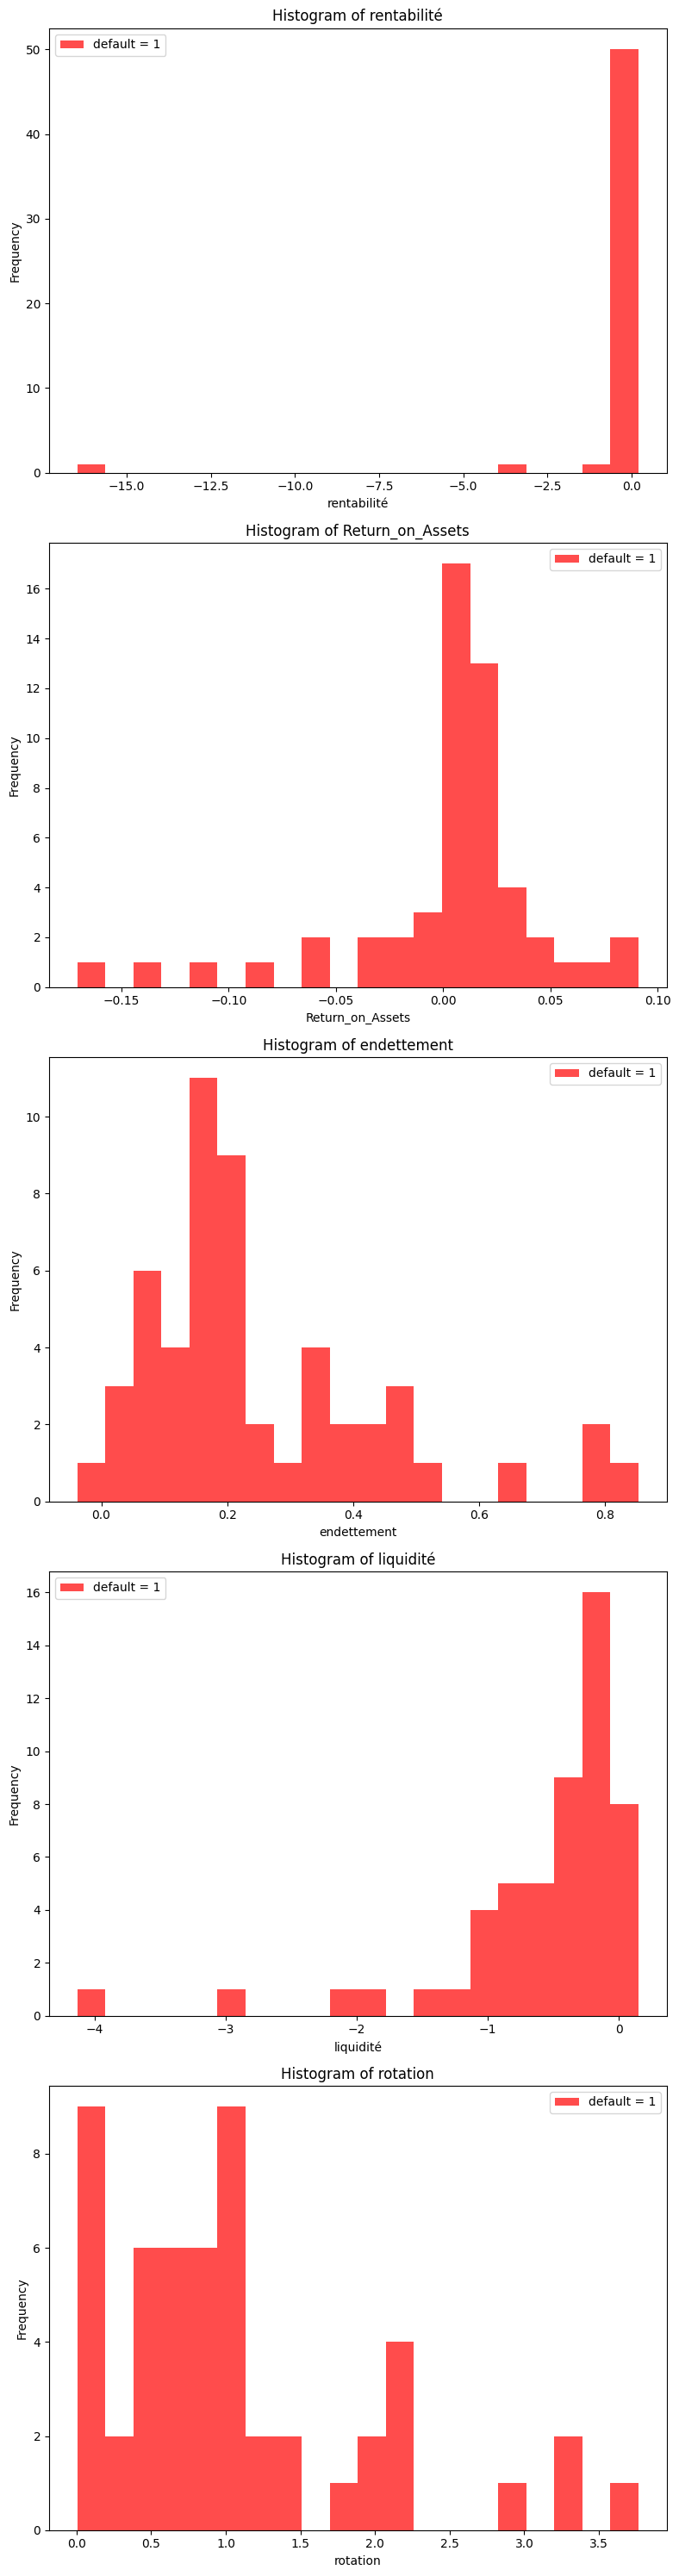

In [406]:
bins = 20  # Number of bins for the histograms

# Create a figure and axis object
fig, axs = plt.subplots(len(ratios_columns), 1, figsize=(8, 6 * len(ratios_columns)))

# Plot histograms for each ratio column with and without default
for i, column in enumerate(ratios_columns):
    # Plot histogram for default = 1
    axs[i].hist(data[data['defaut'] == 1][column], bins=bins, color='red', alpha=0.7, label='default = 1')
    
    # Set labels and title for each subplot
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Histogram of {column}')
    axs[i].legend()  # Add legend
    
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

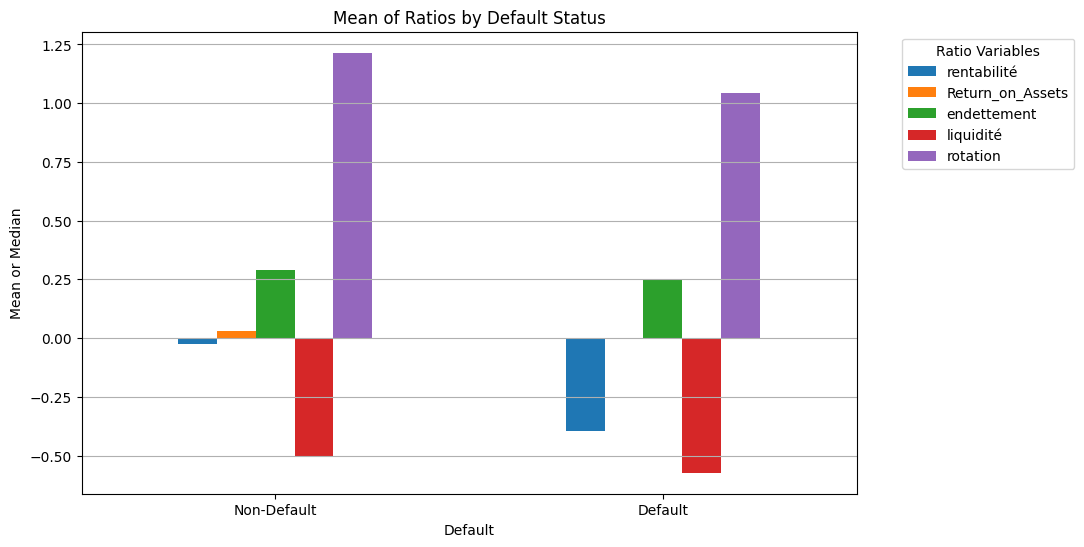

In [407]:
means = data.groupby('defaut')[ratios_columns].mean()

means.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Default')
plt.ylabel('Mean or Median')
plt.title('Mean of Ratios by Default Status')
plt.xticks(np.arange(2), ['Non-Default', 'Default'], rotation=0)
plt.grid(axis='y')
plt.legend(title='Ratio Variables', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Discretization : We can use this technique to optimize the work in a later version

In [408]:
from sklearn.preprocessing import KBinsDiscretizer
# Initialize the discretizer with desired parameters
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

# Fit and transform the selected columns
discretized_data = discretizer.fit_transform(data[ratios_columns])

# Convert the discretized data back to a DataFrame
discretized_df = pd.DataFrame(discretized_data, columns=ratios_columns)
ratios_df=data
# Merge the discretized data back into the original DataFrame
ratios_df[ratios_columns] = discretized_df


In [409]:
discretized_df

,rentabilité,Return_on_Assets,endettement,liquidité,rotation
0,0.0,0.0,4.0,2.0,2.0
1,1.0,1.0,4.0,2.0,3.0
2,1.0,1.0,4.0,2.0,2.0
3,0.0,0.0,1.0,3.0,0.0
4,1.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...
1516,4.0,4.0,3.0,1.0,2.0
1517,1.0,1.0,1.0,2.0,4.0
1518,2.0,2.0,2.0,1.0,2.0
1519,1.0,1.0,1.0,1.0,3.0


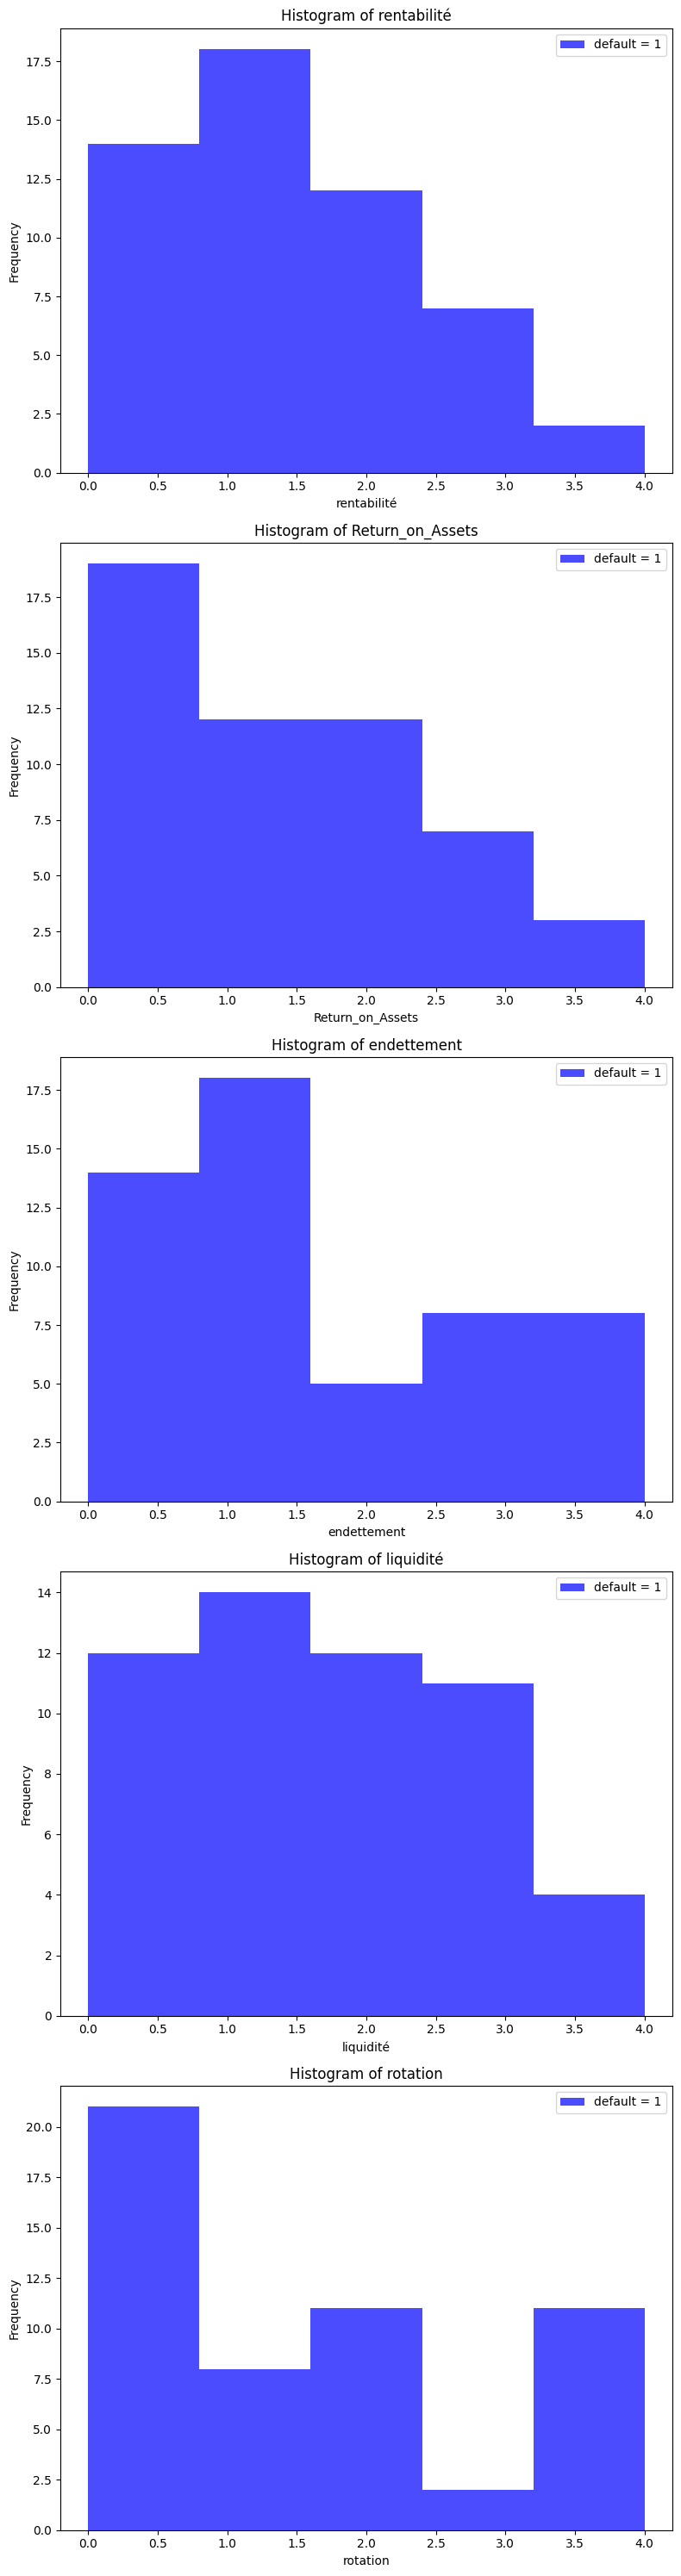

In [410]:
bins = 5  # Number of bins for the histograms

# Create a figure and axis object
fig, axs = plt.subplots(len(ratios_columns), 1, figsize=(8, 6 * len(ratios_columns)))

# Plot histograms for each ratio column with and without default
for i, column in enumerate(ratios_columns):
    # Plot histogram for default = 1
    axs[i].hist(ratios_df[ratios_df['defaut'] == 1][column], bins=bins, color='blue', alpha=0.7, label='default = 1')
    
    # Set labels and title for each subplot
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Histogram of {column}')
    axs[i].legend()  # Add legend
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [411]:
ratios_df.head()

,numtiers,Annee,NUMTIERS_ANNEE,defaut,DATE_DE_CREATION_TIERS,DATE_DE_CREATION_ENTREP,CHIFFRE_AFFAIRES,EXCEDENT_BRUT_EXPLOITATION,RESULTAT_EXPlOITATION,RESULTAT_NET,...,POSITIONNEMENTMARCHE,Categorie_juridique,Cote en bourse,Appartenance a un groupe,Secteurs,rentabilité,Return_on_Assets,endettement,liquidité,rotation
0,5200000007513,2015,5200000007513_2015,0,2008-01-02,1982-01-05,236073240.2,8258201.71,7120503.00,-14040379.78,...,Acteur majeur + de 20% de part de marche,SA,0,0,Transport et Communication,0.0,0.0,4.0,2.0,2.0
1,5200000007513,2016,5200000007513_2016,0,2008-01-02,1982-01-05,258386615.0,4107268.85,2031311.93,2312466.82,...,Acteur majeur + de 20% de part de marche,SA,0,0,Transport et Communication,1.0,1.0,4.0,2.0,3.0
2,5200000007513,2017,5200000007513_2017,0,2008-01-02,1982-01-05,255920255.3,8749135.15,4184388.42,2491167.64,...,Acteur majeur + de 20% de part de marche,SA,0,0,Transport et Communication,1.0,1.0,4.0,2.0,2.0
3,5200000007882,2017,5200000007882_2017,0,1986-03-20,1978-01-16,246866144.0,13528700.69,13243644.41,804568.57,...,Leader,SA,0,1,"Commerce, reparations automobiles et d'article...",0.0,0.0,1.0,3.0,0.0
4,5200000007882,2019,5200000007882_2019,0,1986-03-20,1978-01-16,208897752.4,14645166.04,13164599.60,1896880.51,...,Leader,SA,0,1,"Commerce, reparations automobiles et d'article...",1.0,0.0,0.0,2.0,0.0


### Create the age variable

In [412]:
from datetime import datetime

# Assuming the "creation_date" column is in datetime format
data['DATE_DE_CREATION_ENTREP'] = pd.to_datetime(data['DATE_DE_CREATION_ENTREP'])

# Calculate the age based on the current date
current_date = datetime.now()
data['age'] = (current_date - data['DATE_DE_CREATION_ENTREP']).dt.days/365.25

# Print the DataFrame with the new 'age' column
print(data['age'])

0       42.275154
1       42.275154
2       42.275154
3       46.245038
4       46.245038
          ...    
1516    32.210815
1517    17.566051
1518    22.321697
1519    22.321697
1520    30.368241
Name: age, Length: 1521, dtype: float64


In [414]:
data_encoded = pd.get_dummies(data, columns=['Secteurs'])

### We won't use all the columns as inputs: We'll proceed to calculate the weight of evidence and information value of the features in order to select the most important:

In [415]:
def calculate_woe_iv(feature_data, target_data):
    total_events = np.sum(target_data)
    total_non_events = len(target_data) - total_events
    woe_iv = 0
    
    for value in feature_data.unique():
        event_count = np.sum(target_data[feature_data == value])
        non_event_count = np.sum((feature_data == value) & (target_data == 0))
        
        if event_count == 0 or non_event_count == 0:
            continue
        
        proportion_of_events = event_count / total_events
        proportion_of_non_events = non_event_count / total_non_events
        woe = np.log(proportion_of_events / proportion_of_non_events)
        iv = (proportion_of_events - proportion_of_non_events) * woe
        woe_iv += iv
    
    return woe_iv

def calculate_iv(df, target):
    iv_values = {}
    
    for feature in df.columns:
        if feature != target:
            feature_data = df[feature]
            target_data = df[target]
            
            if feature_data.dtype == 'object':
                feature_data = feature_data.astype('category').cat.codes
            
            iv_values[feature] = calculate_woe_iv(feature_data, target_data)
    
    return iv_values


In [416]:
# Assuming you have already defined the function calculate_iv()

# Calculate IV values for each feature in your data
iv_values = calculate_iv(data, 'defaut')

# Print IV values for each feature
for feature, iv in iv_values.items():
    print(f"IV for {feature}: {iv}")


IV for numtiers: 2.0986531634531986
IV for Annee: 0.44611377771024385
IV for NUMTIERS_ANNEE: 0
IV for DATE_DE_CREATION_TIERS: 1.96163308493875
IV for DATE_DE_CREATION_ENTREP: 2.050353624852758
IV for CHIFFRE_AFFAIRES: 0
IV for EXCEDENT_BRUT_EXPLOITATION: 0
IV for RESULTAT_EXPlOITATION: 0
IV for RESULTAT_NET: 0
IV for FINANCEMENT_PERMANENT: 0
IV for FONDS_DE_ROULEMENT: 0
IV for BESOIN_FONDS_ROULEMENT: 0
IV for CAPITAUX_PROPRES: 0
IV for TRESORIE_NETTE: 0
IV for TOTAL_BILAN: 0
IV for DETTE_FINANCIERE: 0.10681878322299404
IV for ACTIF_CIRCULANT: 0
IV for PASSIF_CIRCULANT: 0
IV for TOTAL_ACTIF: 0
IV for TOTAL_PASSIF: 0
IV for DELAI_REGLEMENT_CLIENTS: 0.12080948224527298
IV for DELAI_REGLEMENT_FOURNISSEURS: 0.0797980010936409
IV for AUTO_FINANCEMENT: 0.003557421077810803
IV for FRAIS_FINANCIERS: 0
IV for STOCK: 0.002327687969527479
IV for EXPERIENCE_MANAGEMENT_MOYENNE_DIRIGEANT: 0.0055170471426930455
IV for DIVERSITE_CLIENTS: 0.006058001466994594
IV for DIVERSITE_FOURNISSEURS: 0.05988229617

In [417]:
data

,numtiers,Annee,NUMTIERS_ANNEE,defaut,DATE_DE_CREATION_TIERS,DATE_DE_CREATION_ENTREP,CHIFFRE_AFFAIRES,EXCEDENT_BRUT_EXPLOITATION,RESULTAT_EXPlOITATION,RESULTAT_NET,...,Categorie_juridique,Cote en bourse,Appartenance a un groupe,Secteurs,rentabilité,Return_on_Assets,endettement,liquidité,rotation,age
0,5200000007513,2015,5200000007513_2015,0,2008-01-02,1982-01-05,236073240.2,8258201.71,7120503.00,-14040379.78,...,SA,0,0,Transport et Communication,0.0,0.0,4.0,2.0,2.0,42.275154
1,5200000007513,2016,5200000007513_2016,0,2008-01-02,1982-01-05,258386615.0,4107268.85,2031311.93,2312466.82,...,SA,0,0,Transport et Communication,1.0,1.0,4.0,2.0,3.0,42.275154
2,5200000007513,2017,5200000007513_2017,0,2008-01-02,1982-01-05,255920255.3,8749135.15,4184388.42,2491167.64,...,SA,0,0,Transport et Communication,1.0,1.0,4.0,2.0,2.0,42.275154
3,5200000007882,2017,5200000007882_2017,0,1986-03-20,1978-01-16,246866144.0,13528700.69,13243644.41,804568.57,...,SA,0,1,"Commerce, reparations automobiles et d'article...",0.0,0.0,1.0,3.0,0.0,46.245038
4,5200000007882,2019,5200000007882_2019,0,1986-03-20,1978-01-16,208897752.4,14645166.04,13164599.60,1896880.51,...,SA,0,1,"Commerce, reparations automobiles et d'article...",1.0,0.0,0.0,2.0,0.0,46.245038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,5200009085869,2018,5200009085869_2018,0,2016-10-28,1992-01-29,238758287.6,26081748.49,19201698.85,14515460.56,...,SA,0,0,"Industries du textile, de l'habillement et des...",4.0,4.0,3.0,1.0,2.0,32.210815
1517,5200009102577,2018,5200009102577_2018,0,2016-11-22,2006-09-21,754817107.4,13480698.43,9017047.93,3259093.51,...,SA,0,1,Transport et Communication,1.0,1.0,1.0,2.0,4.0,17.566051
1518,5200009335765,2018,5200009335765_2018,0,2018-03-01,2001-12-19,165855935.4,12181508.72,10894589.13,3675603.74,...,SARL,0,0,Bâtiments et travaux publics,2.0,2.0,2.0,1.0,2.0,22.321697
1519,5200009335765,2019,5200009335765_2019,0,2018-03-01,2001-12-19,255198134.2,12043765.93,10530357.44,2145015.16,...,SARL,0,0,Bâtiments et travaux publics,1.0,1.0,1.0,1.0,3.0,22.321697


### Time for the Cox model !

In [418]:
from lifelines import CoxPHFitter
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder

In [419]:
# Select relevant columns for survival analysis, such as 'defaut' (event), 'age', and other relevant features
selected_columns = [ 'defaut','NIVEAU_COMPETITIVITE', 'QUALITE_INFORMATION_FINANCIERE', 'REPUTATION',
       'Secteurs', 'rentabilité', 'Return_on_Assets', 'endettement',
       'liquidité', 'rotation','age']

data_selected = data[selected_columns]

# Convert floating-point numbers to integers with rounding up if decimal part >= 0.5
data_selected.loc[:, 'age'] = data_selected['age'].apply(lambda x: int(x) + 1 if isinstance(x, float) and x - int(x) >= 0.5 else x)

# Replace 'Plus de 10 ans' with a numerical value (e.g., 11)
data_selected.loc[:, 'age'] = data_selected['age'].replace('Plus de 10 ans', 11)

# Séparation des données en ensembles d'entraînement et de test
X = data_selected.drop('defaut', axis=1)
y = data_selected['defaut']

# Liste des caractéristiques catégorielles
categorical_features = ['REPUTATION', 'Secteurs']

# Convertir les noms des caractéristiques en indices
categorical_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Application de SMOTE
smote = SMOTENC(categorical_features=categorical_features_indices)


le = LabelEncoder()
for col in X.columns[X.dtypes == "object"]:
    X[col] = le.fit_transform(X[col])
X_NC, y_NC = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_NC, y_NC, test_size=0.2, random_state=42)

X_train['defaut'] = y_train
X_test['defaut'] = y_test

# Fit the Cox proportional hazards model
cox_model = CoxPHFitter()
cox_model.fit(X_train, duration_col='age', event_col='defaut')


C:\Users\nours\AppData\Local\Temp\ipykernel_25892\1145469001.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'age'] = data_selected['age'].apply(lambda x: int(x) + 1 if isinstance(x, float) and x - int(x) >= 0.5 else x)
C:\Users\nours\AppData\Local\Temp\ipykernel_25892\1145469001.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.loc[:, 'age'] = data_selected['age'].replace('Plus de 10 ans', 11)


<lifelines.CoxPHFitter: fitted with 2348 total observations, 1169 right-censored observations>

In [420]:
# Print the summary of the fitted model
cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 2348 total observations, 1169 right-censored observations>
             duration col = 'age'
                event col = 'defaut'
      baseline estimation = breslow
   number of observations = 2348
number of events observed = 1179
   partial log-likelihood = -7837.64
         time fit was run = 2024-04-15 15:25:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
NIVEAU_COMPETITIVITE            -0.29       0.75       0.04            -0.37            -0.21                 0.69                 0.81
QUALITE_INFORMATION_FINANCIERE   0.33       1.39       0.13             0.08             0.58                 1.08                 1.79
REPUTATION                       0.43       1.54       0.04             0.36             0.50                 1.43                 1.66
Secteurs                        -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
rentabilité                     -0.44       0.65       0.06            -0.56            -0.31                 0.57                 0.73
Return_on_Assets                 0.29       1.34       0.07             0.16             0.42                 1.17                 1.53
endettement                     -0.24       0.79       0.03            -0.29            -0.18                 0.75                 0.83
liquidité                       -0.07       0.93       0.02            -0.12            -0.02                 0.89                 0.98
rotation                        -0.05       0.95       0.03            -0.11             0.01                 0.90                 1.01

                                 cmp to     z      p   -log2(p)
covariate                                                      
NIVEAU_COMPETITIVITE               0.00 -6.98 <0.005      38.31
QUALITE_INFORMATION_FINANCIERE     0.00  2.60   0.01       6.75
REPUTATION                         0.00 11.55 <0.005     100.12
Secteurs                           0.00 -0.84   0.40       1.31
rentabilité                        0.00 -6.79 <0.005      36.33
Return_on_Assets                   0.00  4.30 <0.005      15.85
endettement                        0.00 -8.52 <0.005      55.74
liquidité                          0.00 -2.80   0.01       7.61
rotation                           0.00 -1.73   0.08       3.58
---
Concordance = 0.74
Partial AIC = 15693.29
log-likelihood ratio test = 521.66 on 9 df
-log2(p) of ll-ratio test = 351.73

### We have a concordance of 0.74 ! Amazing !

In [421]:
# Access specific coefficients and hazard ratios
coefficients = cox_model.summary['coef']
hazard_ratios = cox_model.summary['exp(coef)']

In [422]:
coefficients
hazard_ratios

covariate
NIVEAU_COMPETITIVITE              0.751939
QUALITE_INFORMATION_FINANCIERE    1.392649
REPUTATION                        1.539154
Secteurs                          0.992862
rentabilité                       0.645597
Return_on_Assets                  1.338907
endettement                       0.790279
liquidité                         0.932717
rotation                          0.949587
Name: exp(coef), dtype: float64

In [423]:
# Check the shape of hazard_ratios
print(hazard_ratios.shape)


(9,)


In [424]:
import matplotlib.pyplot as plt

# Check the shape of hazard_ratios
print("Shape of hazard_ratios:", hazard_ratios.shape)

# Check the shape of data_selected.columns[1:]
print("Shape of columns:", data_selected.columns[1:].shape)

# Make sure hazard_ratios is not empty and has non-zero size
if hazard_ratios is not None and len(hazard_ratios) > 0:
    # Check if shapes are compatible for plotting
    if hazard_ratios.shape[0] == data_selected.columns[1:].shape[0]:
        # Plotting hazard ratios
        plt.figure(figsize=(10, 6))
        plt.barh(data_selected.columns[1:], hazard_ratios.values[1:], color='skyblue')
        plt.xlabel('Hazard Ratio')
        plt.title('Hazard Ratios for Selected Features')
        plt.show()
    else:
        print("Shapes are not compatible for plotting.")
else:
    print("No hazard ratios data to plot.")


Shape of hazard_ratios: (9,)
Shape of columns: (10,)
Shapes are not compatible for plotting.


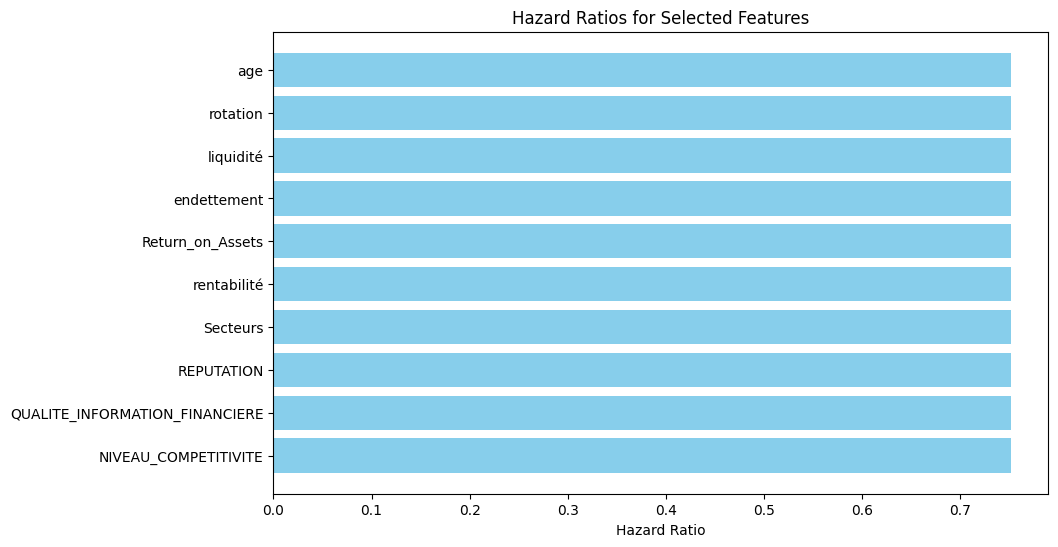

In [425]:
# Make sure hazard_ratios is not empty and has non-zero size
if hazard_ratios is not None and len(hazard_ratios) > 0:
    # Plotting hazard ratios
    plt.figure(figsize=(10, 6))
    plt.barh(data_selected.columns[1:], hazard_ratios.values[0], color='skyblue')  # Use hazard_ratios.values[0] instead of hazard_ratios.values[1:]
    plt.xlabel('Hazard Ratio')
    plt.title('Hazard Ratios for Selected Features')
    plt.show()
else:
    print("No hazard ratios data to plot.")


In [426]:
cox_model.check_assumptions(X_train, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2348 total observations, 1169 right-censored observations>
         test_name = proportional_hazard_test

---
                                     test_statistic      p  -log2(p)
NIVEAU_COMPETITIVITE           km             13.36 <0.005     11.92
                               rank           19.22 <0.005     16.39
QUALITE_INFORMATION_FINANCIERE km             34.37 <0.005     27.71
                               rank           39.07 <0.005     31.19
REPUTATION                     km            139.10 <0.005    104.24
                               rank          100.43 <0.005     76.11
Return_on_Assets               km             43.81 <0.005     34.69
                               rank           64.85 <0.005     50.13
Secteurs                       km            123.96 <0.005     93.23
                               rank          194.25 <0.005    144.25
endettement                    km             17.11 <0.005     14.79
                               rank           20.74 <0.005     17.54
liquidité                      km             23.67 <0.005     19.74
                               rank           25.82 <0.005     21.35
rentabilité                    km             54.82 <0.005     42.78
                               rank           75.29 <0.005     57.77
rotation                       km             13.66 <0.005     12.15
                               rank            7.90 <0.005      7.66



1. Variable 'NIVEAU_COMPETITIVITE' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 4), you can include `strata=['NIVEAU_COMPETITIVITE',
...]` in the call in `.fit`. See documentation in link [E] below.

2. Variable 'QUALITE_INFORMATION_FINANCIERE' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'QUALITE_INFORMATION_FINANCIERE' might be
incorrect. That is, there may be non-linear terms missing. The proportional hazard test used is very
sensitive to incorrect functional forms. See documentation in link [D] below on how to specify a
functional form.

   Advice 2: try binning the variable 'QUALITE_INFORMATION_FINANCIERE' using pd.cut, and then
specify it in `strata=['QUALITE_INFORMATION_FINANCIERE', ...]` in the call in `.fit`. See
documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


3. Variable 'R

[]

In [427]:
from lifelines.statistics import proportional_hazard_test

In [428]:
proportional_hazard_test(fitted_cox_model=cox_model, training_df=X_train, time_transform='log')

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = log
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2348 total observations, 1169 right-censored observations>
         test_name = proportional_hazard_test

---
                                test_statistic      p  -log2(p)
NIVEAU_COMPETITIVITE                     13.08 <0.005     11.71
QUALITE_INFORMATION_FINANCIERE           34.26 <0.005     27.63
REPUTATION                              120.21 <0.005     90.51
Return_on_Assets                         50.35 <0.005     39.50
Secteurs                                145.34 <0.005    108.77
endettement                              25.26 <0.005     20.93
liquidité                                28.57 <0.005     23.40
rentabilité                              58.10 <0.005     45.19
rotation                                  9.56 <0.005      8.98

In [434]:

c_index = cox_model.score(X_train, scoring_method="concordance_index")
print(f"Concordance Index: {c_index}")

Concordance Index: 0.7393985598455467


In [429]:

c_index = cox_model.score(X_test, scoring_method="concordance_index")
print(f"Concordance Index: {c_index}")

Concordance Index: 0.7099288493863547


In [430]:
test_predictions = cox_model.predict_expectation(X_test)

In [431]:
# Add the predicted survival times to the test set
test_set_with_predictions = X_test.assign(predicted_survival=test_predictions.values)

# Sort the individuals by predicted survival time
sorted_test_set = test_set_with_predictions.sort_values(by='predicted_survival')

sorted_test_set.head(20)


,NIVEAU_COMPETITIVITE,QUALITE_INFORMATION_FINANCIERE,REPUTATION,Secteurs,rentabilité,Return_on_Assets,endettement,liquidité,rotation,age,defaut,predicted_survival
289,0,1,3,5,0.000000,0.000000,0.000000,0.000000,3.000000,25.363450,0,18.012875
926,0,0,3,5,0.000000,1.000000,0.000000,0.000000,4.000000,28.000000,0,18.797269
2652,1,1,3,3,1.000000,2.000000,0.099805,0.199610,4.000000,14.816990,1,19.965100
2785,1,0,3,3,1.013752,2.986248,0.013752,2.986248,3.972496,11.387055,1,22.434694
368,0,0,3,5,1.000000,2.000000,0.000000,3.000000,4.000000,16.000000,0,22.560051
2117,1,1,3,3,1.000000,2.221300,0.778700,2.221300,4.000000,12.770681,1,22.609808
940,0,0,3,16,0.000000,0.000000,0.000000,2.000000,2.000000,36.344969,0,23.214181
2663,1,0,3,5,1.000000,1.974509,0.000000,0.000000,3.949019,15.025491,1,23.594479
1971,0,0,3,4,1.075913,1.075913,0.075913,1.075913,2.924087,19.884027,1,24.172797
2119,0,0,3,9,0.693229,0.462153,0.462153,0.693229,1.000000,42.032963,1,24.340746


### Clearly, the results can be improved. We can see that the data issues resulted in non logical results like the statistical tests output.


## We can try other algorithms like random forest, logistic regression...

In [ ]:
from sklearn.metrics import classification_report
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
# Prédiction sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Affichage du rapport de classification
print(classification_report(y_test, y_pred))

In [ ]:
# Prédiction des probabilités de la classe positive
y_pred_proba = rf_model.predict_proba(X_test)[::,1]

# Calcul de la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Courbe ROC (aire = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
y_pred_lg = lg_model.predict(X_test)
print(classification_report(y_test, y_pred_lg))

## At the end, this was an opportunity to practise and build a default probibilty predictor from scratch using the Cox model, which is suitable for our data type (panel data)

### You can use this project for academic purposes